H ομάδα μας (100) αποτελείται από τα παρακάτω μέλη: 
* Αστρινάκης Νικόλαος (03117008)
* Καπαρού Αλεξάνδρα (03117100)
* Ταμπακάκης Χρήστος (03117042)

# Εργαστηριακή Άσκηση 3. Βαθιά μάθηση.

#**Image Captioning**

In [ ]:
from google.colab import drive
import os
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## Σύνολο Δεδομένων

Αρχικά φορτώνουμε το σύνολο δεδομένων `flickr30k-images-ecemod` που αποτελείται από τα `image_dir`, `train_captions.csv`, `test_images.csv`.

In [ ]:
# Download image files
image_folder = '/images/'
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
PATH = os.path.dirname(image_zip) + image_folder
os.remove(image_zip)

4376395776/4376381805 [==============================] - 5005s 1us/step


In [ ]:
# Download train captions file
train_captions_file = tf.keras.utils.get_file('train_captions.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_captions.csv',
                                           extract=False)

# Download test files list
test_images_file = tf.keras.utils.get_file('test_images.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_images.csv',
                                           extract=False)

40960/29242 [==========================================] - 0s 0us/step


Στην συνέχεια υλοποιούμε δύο συναρτήσεις, η μία χρησιμοποιείται για το διάβασμα του αρχείου (`load_fp`) και η δεύτερη για την αντιστοίχιση των captions στην κατάλληλη εικόνα και την δημιουργία ενός dictionary (`image_captions`).

In [ ]:
test_images_file = "./test_images.csv"
train_captions_file = "./train_captions.csv"

In [ ]:
# Load the document file into memory
def load_fp(filename):
  # Open file to read
   file = open(filename, 'r', encoding="utf8")
   text = file.read()
   file.close()
   return text

#creates a dictionary that maps each image with the corresponding captions
def image_captions(filename):
   file = load_fp(filename)
   captions = file.split('\n')
   descriptions ={}
   for caption in captions[:-1]:
       image, number, caption = caption.split('| ')
       if image not in descriptions:
           descriptions[image] = ["<start> " + caption.strip(" .") + " <end>"]
       else:
           descriptions[image].append("<start> " + caption.strip(" .") + " <end>")
   return descriptions


In [ ]:
descriptions = image_captions(train_captions_file)

Ένα παράδειγμα χρήσης της συνάρτησης για μία τυχαία εικόνα φαίνεται παρακάτω:

In [ ]:
descriptions['_1000070808.jpg']

['<start> A little girl holds orange lilies while others celebrate an occasion in a garden setting <end>',
 '<start> A little girl at a wedding holds a bouquet of orange flowers <end>',
 '<start> Young girl in orange dress holding orange flowers <end>',
 '<start> a girl at a wedding holding some orange flowers <end>',
 '<start> A girl holds a bouquet of flowers <end>']

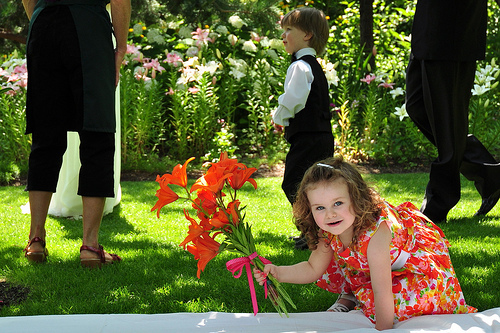

In [ ]:
Image.open("./image_dir/_1000070808.jpg")

Στην συνέχεια, για να μειώσουμε το μέγεθος του training set διαλέγουμε 6000 δείγματα εικόνων (με περίπου 5 captions η κάθε μία άρα συνολικα 30000 captions).

In [ ]:
image_paths = list(descriptions.keys())
random.Random(2).shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = descriptions[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
len(img_name_vector)

30000

Τυπωνοντας το πρώτο caption μαζί με την αντίστοιχη εικόνα παίρνουμε τα παρακάτω:

<start> A football player in a green uniform is trying to catch the ball , while his opponent , in a blue uniform , tries to stop him <end>


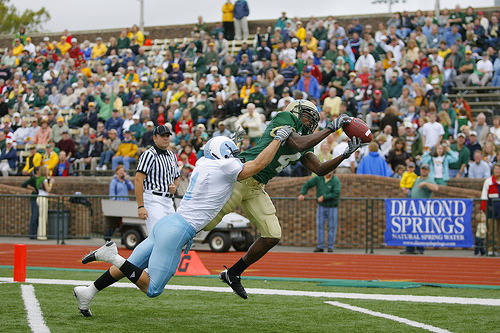

In [ ]:
print(train_captions[0])
Image.open("./image_dir/" + img_name_vector[0])

##Αρχικό μοντέλο

Στην αρχή μας ζητήθηκε να εκπαιδεύσουμε και να αξιολογήσουμε το μοντέλο InceptionV3 προκειμένου να έχουμε μία baseline τιμή.

####Φόρτωση αρχείων και επεξεργασία

Αρχικά ορίζουμε το μοντέλο και επεξεργαζόμαστε κατάλληλα τις εικόνες χρησιμοποιώντας την `tf.keras.applications.inception_v3.preprocess_input`.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file('./image_dir/' + image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save("./inception/" + path_of_feature, bf.numpy())

Για να αποθηκεύσουμε τα npy αρχεία εκτελούμε τον παρακάτω κώδικα:

In [ ]:
# !cp ./*.npy ./neural_networks_nekt/npy_data_original

Εκτελούμε μία βασική προεπεξεργασία κειμένου στην οποία αφαιρούμε τα σημεία στίξης. Παρατηρήσαμε ότι η standardize του tutorial ήταν ελλειπής και δεν αφαιρούσε σωστά τα σημεία στίξης, επομένως την διορθώσαμε.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
random.seed(200)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

Ορίζουμε τις παραμέτρους κατάλληλα:

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  # img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  img_name = img_name.decode('utf-8')
  img_tensor = np.load( './inception/' + img_name.split("/")[-1] + '.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
random.seed(300)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

###Ορισμός κλάσεων

Ορίζουμε κατάλληλα τις κλάσεις `BahdanauAttention`, `CNN_Encoder`, `RNN_Decoder`:

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

####Training


---



Για να ορίσουμε το αντίστοιχο checkpoint:

In [ ]:
checkpoint_path = "./checkpoints/original/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

Αρχικοποιούμε την γραφική παράσταση:

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target, encoder, decoder):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, encoder, decoder)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 2 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.2507
Epoch 1 Batch 100 Loss 1.4161
Epoch 1 Batch 200 Loss 1.1835
Epoch 1 Batch 300 Loss 1.1684
Epoch 1 Loss 1.247153
Time taken for 1 epoch 296.98 sec

Epoch 2 Batch 0 Loss 1.0463
Epoch 2 Batch 100 Loss 0.9065
Epoch 2 Batch 200 Loss 0.9939
Epoch 2 Batch 300 Loss 0.9321
Epoch 2 Loss 0.991517
Time taken for 1 epoch 207.97 sec

Epoch 3 Batch 0 Loss 0.9424
Epoch 3 Batch 100 Loss 0.9669
Epoch 3 Batch 200 Loss 0.8962
Epoch 3 Batch 300 Loss 0.8315
Epoch 3 Loss 0.902352
Time taken for 1 epoch 205.72 sec

Epoch 4 Batch 0 Loss 0.9188
Epoch 4 Batch 100 Loss 0.8752
Epoch 4 Batch 200 Loss 0.8868
Epoch 4 Batch 300 Loss 0.7527
Epoch 4 Loss 0.841607
Time taken for 1 epoch 202.04 sec

Epoch 5 Batch 0 Loss 0.7777
Epoch 5 Batch 100 Loss 0.7866
Epoch 5 Batch 200 Loss 0.7348
Epoch 5 Batch 300 Loss 0.7253
Epoch 5 Loss 0.792267
Time taken for 1 epoch 204.72 sec

Epoch 6 Batch 0 Loss 0.7839
Epoch 6 Batch 100 Loss 0.7739
Epoch 6 Batch 200 Loss 0.7618
Epoch 6 Batch 300 Loss 0.6980
Epoch 6

#####Loss plot

Παρατηρούμε ότι ξεκινάμε αρχικά με μία μεγάλη τιμή loss (1.24) το οποίο μετά από 10 εποχές μειώνεται σχεδόν στο μισό (0.60). Ακόμα, όσον αφορά τον χρόνο εκπαίδευσης, βλέπουμε ότι χρειάζεται περισσότερος χρόνος στην πρώτη εποχή, ενώ στις επόμενες ο χρόνος είναι γύρω στα 3 λεπτά/εποχή.

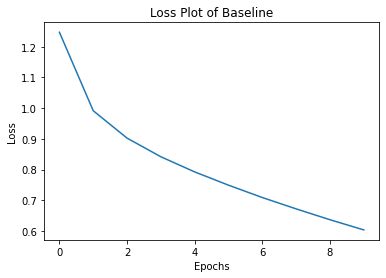

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot of Baseline')
plt.show()

#####Backup

In [ ]:
import joblib
joblib.dump(encoder, './models/original/encoder.pkl')
joblib.dump(decoder, './models/original/decoder.pkl')

####Evaluation

Προκειμένου να αξιολογήσουμε τα αποτελέσματα μετά από την εκπαίδευση ορίζουμε τις παρακάτω συναρτήσεις:

#####Ορισμός συναρτήσεων

In [ ]:
def evaluate(image, encoder, decoder):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = ['<start>']

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open('./image_dir/' + image))

    fig = plt.figure(figsize=(25, 25))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

#####Έλεγχος

Τα captions που παράγει το μοντέλο μας φαίνονται παρακάτω. Παρατηρούμε ότι βρίσκει το βασικό στοιχείο της φωτογραφίας που είναι το ποδήλατο, ωστόσο κάνει επανάληψη λέξεων οι οποίες δεν βοηθάνε κάπου.

Real Caption: <start> a boy with a helmet mountain bikes through the woods <end>
Prediction Caption: <start> a biking bike rider how to catch a bike while riding a bike <end>


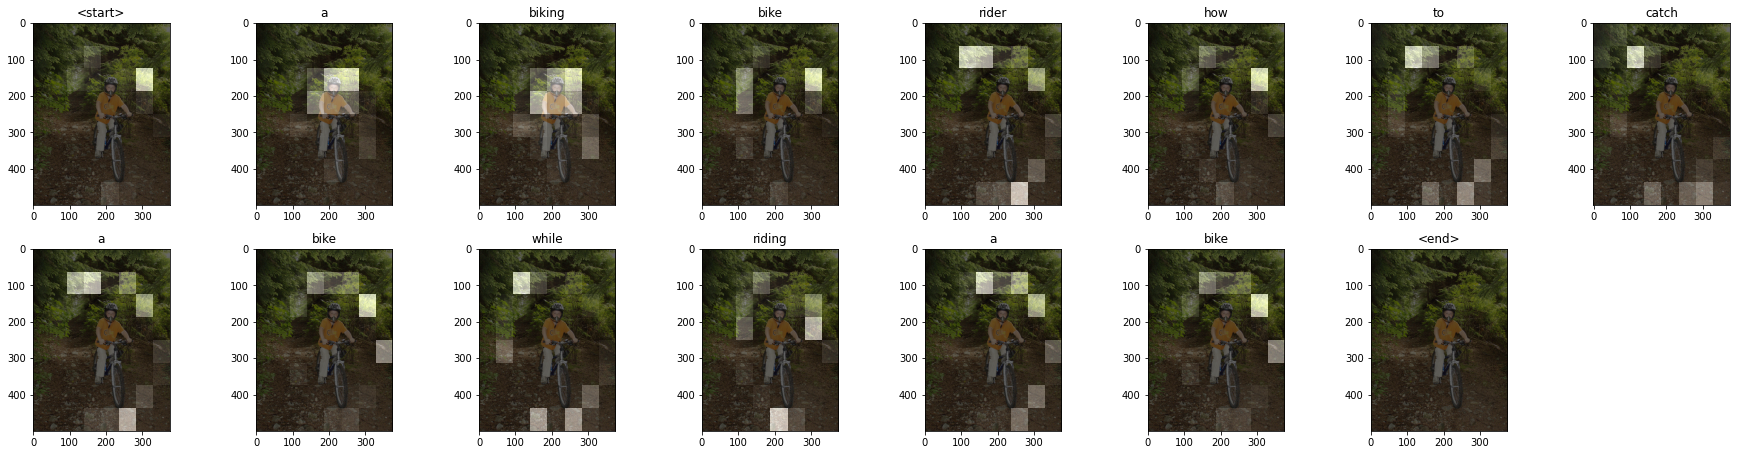

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder, decoder)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

####Validation

Στην συνέχεια προχωράμε στον υπολογισμό του bleu score στο validation. Στο σημείο αυτό να διευκρινίσουμε ότι κατά τον υπολογισμό των bleu score, bleu sentence δεν λάβαμε υπόψιν τα `<start>`, `<end>` που περιείχαν τα captions καθώς κάτι τέτοιο θα αύξανε θετικά τα σκορ και θα καθιστούσε τα αποτελέσματα μη ακριβή.

#####Ορισμός συναρτήσων `sentence_bleu` και `corpus_bleu`.

In [ ]:
## imports

import sys
import math
import warnings

from nltk.util import ngrams
from fractions import Fraction
from collections import Counter

In [ ]:
## auxilary functions

def modified_precision(references, hypothesis, n):
    counts = Counter(ngrams(hypothesis, n)) if len(hypothesis) >= n else Counter()
    max_counts = {}

    for reference in references:
        reference_counts = (
            Counter(ngrams(reference, n)) if len(reference) >= n else Counter()
        )
        for ngram in counts:
            max_counts[ngram] = max(max_counts.get(ngram, 0), reference_counts[ngram])

    clipped_counts = {
        ngram: min(count, max_counts[ngram]) for ngram, count in counts.items()
    }

    numerator = sum(clipped_counts.values())
    denominator = max(1, sum(counts.values()))

    return Fraction(numerator, denominator, _normalize = False)

def closest_ref_length(references, hyp_len):
    ref_lens = (len(reference) for reference in references)
    closest_ref_len = min(
        ref_lens, key=lambda ref_len: (abs(ref_len - hyp_len), ref_len)
    )
    return closest_ref_len

def brevity_penalty(closest_ref_len, hyp_len):
    if hyp_len > closest_ref_len:
        return 1
    elif hyp_len == 0:
        return 0
    else:
        return math.exp(1 - closest_ref_len / hyp_len)

In [ ]:
## smoothing function class

class SmoothingFunction:
    def __init__(self, epsilon = 0.1, alpha = 5, k = 5):
        self.epsilon = epsilon
        self.alpha = alpha
        self.k = k
 
    def method0(self, p_n, *args, **kwargs):
        p_n_new = []
        for i, p_i in enumerate(p_n):
            if p_i.numerator != 0:
                p_n_new.append(p_i)
            else:
                _msg = str(
                    "\nThe hypothesis contains 0 counts of {}-gram overlaps.\n"
                    "Therefore the BLEU score evaluates to 0, independently of\n"
                    "how many N-gram overlaps of lower order it contains.\n"
                    "Consider using lower n-gram order or use "
                    "SmoothingFunction()"
                ).format(i + 1)
                warnings.warn(_msg)
                p_n_new.append(sys.float_info.min)
        return p_n_new


    def method1(self, p_n, *args, **kwargs):
        return [
            (p_i.numerator + self.epsilon) / p_i.denominator
            if p_i.numerator == 0
            else p_i
            for p_i in p_n
        ]


    def method2(self, p_n, *args, **kwargs):
        return [
            Fraction(p_n[i].numerator + 1, p_n[i].denominator + 1, _normalize=False)
            if i != 0
            else p_n[0]
            for i in range(len(p_n))
        ]


    def method3(self, p_n, *args, **kwargs):
        incvnt = 1  

        for i, p_i in enumerate(p_n):
            if p_i.numerator == 0:
                p_n[i] = 1 / (2 ** incvnt * p_i.denominator)
                incvnt += 1
        return p_n


    def method4(self, p_n, references, hypothesis, hyp_len=None, *args, **kwargs):
        incvnt = 1
        hyp_len = hyp_len if hyp_len else len(hypothesis)
        for i, p_i in enumerate(p_n):
            if p_i.numerator == 0 and hyp_len > 1:
                numerator = 1 / (2 ** incvnt * self.k / math.log(hyp_len))
                p_n[i] = numerator / p_i.denominator
                incvnt += 1
        return p_n


    def method5(self, p_n, references, hypothesis, hyp_len=None, *args, **kwargs):
        hyp_len = hyp_len if hyp_len else len(hypothesis)
        m = {}

        p_n_plus1 = p_n + [modified_precision(references, hypothesis, 5)]
        m[-1] = p_n[0] + 1
        for i, p_i in enumerate(p_n):
            p_n[i] = (m[i - 1] + p_i + p_n_plus1[i + 1]) / 3
            m[i] = p_n[i]
        return p_n


    def method6(self, p_n, references, hypothesis, hyp_len=None, *args, **kwargs):
        hyp_len = hyp_len if hyp_len else len(hypothesis)
        assert p_n[2], "This smoothing method requires non-zero precision for bigrams."
        for i, p_i in enumerate(p_n):
            if i in [0, 1]:
                continue
            else:
                pi0 = 0 if p_n[i - 2] == 0 else p_n[i - 1] ** 2 / p_n[i - 2]
                m = p_i.numerator
                l = sum(1 for _ in ngrams(hypothesis, i + 1))
                p_n[i] = (m + self.alpha * pi0) / (l + self.alpha)
        return p_n


    def method7(self, p_n, references, hypothesis, hyp_len=None, *args, **kwargs):
        hyp_len = hyp_len if hyp_len else len(hypothesis)
        p_n = self.method4(p_n, references, hypothesis, hyp_len)
        p_n = self.method5(p_n, references, hypothesis, hyp_len)
        return p_n


In [ ]:
## corpus bleu

def corpus_bleu(
    list_of_references,
    hypotheses,
    weights = (0.4, 0.3, 0.2, 0.1),
    auto_reweigh = False,
    smoothing_function = SmoothingFunction().method1
):
    p_numerators = Counter()  
    p_denominators = Counter()  
    hyp_lengths, ref_lengths = 0, 0

    assert len(list_of_references) == len(hypotheses), (
        "The number of hypotheses and their reference(s) should be the same."
    )

    try:
        weights[0][0]
    except TypeError:
        weights = [weights]
    max_weight_length = max(len(weight) for weight in weights)

    for references, hypothesis in zip(list_of_references, hypotheses):
        references = [ref[1:-1] for ref in references]
        hypothesis = hypothesis[1:-1]
        for i in range(1, max_weight_length + 1):
            p_i = modified_precision(references, hypothesis, i)
            p_numerators[i] += p_i.numerator
            p_denominators[i] += p_i.denominator

        hyp_len = len(hypothesis)
        hyp_lengths += hyp_len
        ref_lengths += closest_ref_length(references, hyp_len)

    bp = brevity_penalty(ref_lengths, hyp_lengths)
    
    p_n = [
        Fraction(p_numerators[i], p_denominators[i], _normalize = False)
        for i in range(1, max_weight_length + 1)
    ]

    if p_numerators[1] == 0:
        return 0 if len(weights) == 1 else [0] * len(weights)

    p_n = smoothing_function(
        p_n, references=references, hypothesis=hypothesis, hyp_len=hyp_lengths
    )

    bleu_scores = []
    for weight in weights:
        if auto_reweigh:
            if hyp_lengths < 4 and weight == (0.25, 0.25, 0.25, 0.25):
                weight = (1 / hyp_lengths,) * hyp_lengths

        s = (w_i * math.log(p_i) for w_i, p_i in zip(weight, p_n) if p_i > 0)
        s = bp * math.exp(math.fsum(s))
        bleu_scores.append(s)
    return bleu_scores[0] if len(weights) == 1 else bleu_scores

In [ ]:
## sentence bleu

def sentence_bleu(
    references,
    hypothesis,
    weights = (0.4, 0.3, 0.2, 0.1),
    auto_reweigh = False,
    smoothing_function = SmoothingFunction().method1
):
    return corpus_bleu(
        [references],
        [hypothesis],
        weights,
        auto_reweigh,
        smoothing_function
        
  )

#####Έλεγχος

In [ ]:
from tqdm import tqdm

In [ ]:
hypotheses = []
references = []

for img in tqdm(img_name_val_keys):
  refs = img_to_cap_vector[img]
  refs = [[tf.compat.as_text(index_to_word(i).numpy()) for i in lst if i not in [0]] for lst in refs]
  references.append(refs)

  hyp, _ = evaluate(img, encoder, decoder)
  hypotheses.append(hyp)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [32:11<00:00,  1.61s/it]


#####Backup

In [ ]:
joblib.dump(hypotheses, './models/bleu/original/hypotheses.pkl')
joblib.dump(references, './models/bleu/original/references.pkl')

#####Bleu Scores

Φορτώνουμε τα αρχεία που έχουμε αποθηκεύσει:

In [ ]:
hypotheses = joblib.load('./models/bleu/original/hypotheses.pkl')
references = joblib.load('./models/bleu/original/references.pkl')

Υπολογίζουμε το μέγιστο sentence bleu του dataset μας καθώς και το corpus bleu όλων των captions. Παρατηρούμε ότι το υψηλότερο sentence bleu αγγίζει το 0.9, τιμή η οποία είναι οριακά βέλτιστη, δηλαδή ότι στην συγκεκριμένη εικόνα έχει βρει ένα σχεδόν πλήρως ρεαλιστικό caption. Το corpus bleu από την άλλη βλέπουμε ότι έχει σαν τιμή το 0.1, ικανοποιητική τιμή όσον αφορά την παραγωγή των captions μιας και όπως γνωρίζουμε το corpus bleu δεν είναι ο μέσος όρος των corpus sentences, επομένως δεν περιμέναμε κάποια τιμή κοντά στο 0.9.

In [ ]:
maxbleu = 0
maxi = None

for i in range(len(references)):
  tmp = sentence_bleu(references[i], hypotheses[i])

  if tmp > maxbleu:
    maxbleu = tmp
    maxi = i

In [ ]:
print("Real Captions:")
for i in references[maxi]:
  print(" ".join(i))

print()
print("Predicted Caption:")
print(" ".join(hypotheses[maxi]))

print("Highest Sentence Bleu Score:", sentence_bleu(references[maxi], hypotheses[maxi]))

Real Captions:
<start> a young woman wearing a yellow shirt and offwhite shorts is reading a book while sitting on a park bench <end>
<start> a man with black hair is lying across a park bench reading a book <end>
<start> a woman is sitting on a bench reading in a park <end>
<start> woman reading a book on a park bench outside <end>
<start> a woman sitting on a bench reading a book <end>

Predicted Caption:
<start> a woman is sitting on a park bench <end>
Highest Sentence Bleu Score: 0.8824969025845955


In [ ]:
result = corpus_bleu(references, hypotheses)
print("Corpus Bleu Score =", result)

Corpus Bleu Score = 0.10626050967759249


##Βελτιώσεις (και παραδοτέα)

Αφού έχουμε αποκτήσει μία εικόνα της επίδοσης του έτοιμου δικτύου με μετρικές τα loss και χρόνος εκπαίδευσης στο train και BLEU score στο validation, στην συνέχεια μας ζητήθηκε να εκτελέσουμε ορισμένες βελτιώσεις προκειμένου να έχουμε καλύτερα αποτελέσματα.

###Προεπεξεργασία κειμένου

Προκειμένου να βελτιωθεί η επίδοση, χρειάζεται μια προεπεξεργασία των captions προκειμένου να είναι στην κατάλληλη μορφή.

#####Μείωση των μηκών των λέξεων

* Αρχικά παρατηρήσαμε με το παρακάτω ιστόγραμμα ότι τα captions έχουν διαφορετικά μήκη:

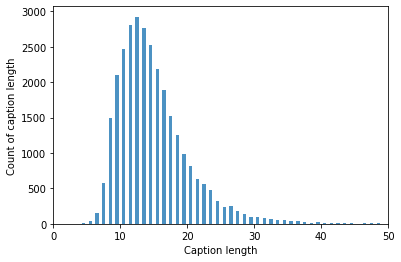

In [ ]:
import numpy as np
import random
from matplotlib import pyplot as plt

data = [len(train_captions[i].split()) for i in range (len(train_captions))]

# fixed bin size
bins = np.arange(0, 50, 1) # fixed bin size
plt.xlim([0, 50])
plt.hist(data, bins = bins, alpha = 0.8, rwidth = 0.5)
plt.xlabel('Caption length')
plt.ylabel('Count of caption length')
plt.show()

Μας ζητήθηκε να κρατήσουμε 25 έως 35 διαφορετικά μήκη. Ο λόγος για αυτό είναι ότι το νευρωνικό απαιτεί εισόδους ίδιου μήκους επομένως αν υπάρχουν πολύ μεγάλες αποκλίσεις μέσω των μηκών (παραδείγματος χάρη αν το ένα μήκος είναι 2 και το άλλο 50 τότε θα πρέπει να γίνεi padding στο 2 ώστε να φτάσει στο 50 και άρα θα απαιτούσε περισσότερη μνήμη). Γι'αυτό τον λόγο κρατήσαμε τα μήκη 5 μέχρι 30, δηλαδή 25 διαφορετικά μήκη.

In [ ]:
len(train_captions)

30000

Εφόσον πλέον αλλάξαμε τον αριθμό των captions που κρατάμε, πρέπει να γίνει η κατάλληλη αλλαγή στα `train_captions` και `img_name_vector`:

In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = [x for x in descriptions[image_path] if len(x.split()) >= 5 and len(x.split()) <= 30]
  
  if(len(caption_list) > 0):
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

Παρατηρούμε ότι πλέον το μήκος των `train_captions` από 30000 μειώθηκε σε 29507, άρα διαγράφηκαν 493 captions με πολύ μικρό ή πολύ μεγάλο μήκος.

In [ ]:
len(train_captions)

29507

In [ ]:
@tf.function
def train_step(img_tensor, target, encoder, decoder):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

#####Κανονικοποίηση/Επέκταση του vocabulary

* Επίσης, για την συγκεκριμένη εφαρμογή χρειάστηκε να αφαιρέσουμε τους special characters. Κρίθηκε απαραίτητο να μην εκτελέσουμε stemming καθώς το generative model που θα υλοποιήσουμε στην συνέχεια θα πρέπει να φτιάχνει φυσικές προτάσεις, επομένως θα πρέπει το vocabulary να περιέχει και τους συνδέσμους, αντωνυμίες κλπ. Γι'αυτόν τον λόγο δεν αφαιρέθηκαν ούτε τα stopwords. Σαν επιπλέον φίλτρα κανονικοποίησης προσθέσαμε το φίλτρο όπου όταν υπάρχουν λέξεις με απόστροφο (π.χ. you 're), αντί να έχουν κενό μεταξύ τους (κάτι το οποίο θα έκοβε την λέξη στα δύο εξαιτίας του tokenizer), αφαιρέσαμε το κενό και το θεωρήσαμε μία λέξη. Επιπλέον, όταν υπάρχουν δύο κενά συνεχόμενα επιλέξαμε να τα συγχωνεύουμε σε ένα κενό ώστε να μην αναγνωρίζει ο tokenizer το κενό σαν ξεχωριστή λέξη. Επιπλέον, αυξήσαμε το μέγεθος του vocabulary σε 7000 από 5000 που ήταν πριν καθώς θεωρήσαμε ότι με τον εμπλουτισμό του λεξιλογίου θα παράγονται πιο ακριβείς προτάσεις.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization 
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  inputs = tf.strings.regex_replace(inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]", "")
  inputs = tf.strings.regex_replace(inputs, r" '", "'")
  return tf.strings.regex_replace(inputs, r" +", " ")

# Max word count for a caption.
max_length = 30
# Use the top 7000 words for a vocabulary.
vocabulary_size = 7000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
print(sorted(tokenizer.get_vocabulary()))

['', '1', '10', '100', '11', '12', '1299', '13', '14', '15', '16', '2', "20's", '2008', '2010', '2012', '22', '23', '24', '25', '28', '2nd', '3', '30', '33', '330', '3rd', '4', '4th', '4wheel', '4wheeler', '5', '541', '55th', '56', '5k', '6', '7', '8', '9', '90th', '93', '<end>', '<start>', '[UNK]', 'a', "a'", 'abandoned', 'able', 'aboard', 'about', 'above', 'accents', 'accepting', 'access', 'accessories', 'accident', 'accompanied', 'accordion', 'account', 'acoustic', 'across', 'act', 'acting', 'action', 'actively', 'activities', 'activity', 'actors', 'actresses', 'acts', 'acura', 'ad', 'add', 'additional', 'addresses', 'addressing', 'adidas', 'adjacent', 'adjust', 'adjusting', 'adjustments', 'adjusts', 'admire', 'admires', 'admiring', 'adolescent', 'adolescents', 'adorable', 'adorned', 'adult', "adult's", 'adults', 'adventure', 'advertisement', 'advertisements', 'advertising', 'aerial', 'aerodynamic', 'affection', 'aframe', 'africa', 'african', 'africanamerican', 'africans', 'after', 

Παρατηρούμε παραπάνω ότι το vocabulary περιέχει αριθμούς τους οποίους επιλέξαμε να μην αφαιρέσουμε μιας και κρίναμε ότι περιέχουν χρήσιμη πληροφορία σε ένα caption.

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

####Training

---



Στην συνέχεια προχωρήσαμε στην εκπαίδευση του InceptionV3 μοντέλου χρησιμοποιώντας αυτή την φορά μόνο τα captions που πληρούν τα άνωθεν κριτήρια. Για τις βελτιώσεις που κάνουμε από εδώ και πέρα, προκειμένου να γλιτώσουμε χρόνο αλλά και πόρους, αποφασίσαμε η εκπαίδευση να πραγματοποιηθεί για 5 μόνο εποχές.

In [ ]:
checkpoint_path = "./checkpoints/preprocessed/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

Αρχικοποιούμε την γραφική παράσταση:

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, encoder, decoder)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.4297
Epoch 1 Batch 100 Loss 1.3357
Epoch 1 Batch 200 Loss 1.0986
Epoch 1 Batch 300 Loss 0.9432
Epoch 1 Loss 1.174147
Time taken for 1 epoch 325.73 sec

Epoch 2 Batch 0 Loss 1.0124
Epoch 2 Batch 100 Loss 0.9557
Epoch 2 Batch 200 Loss 0.9486
Epoch 2 Batch 300 Loss 0.9407
Epoch 2 Loss 0.963168
Time taken for 1 epoch 219.81 sec

Epoch 3 Batch 0 Loss 1.0057
Epoch 3 Batch 100 Loss 0.8568
Epoch 3 Batch 200 Loss 0.8471
Epoch 3 Batch 300 Loss 0.8613
Epoch 3 Loss 0.883475
Time taken for 1 epoch 217.13 sec

Epoch 4 Batch 0 Loss 0.9473
Epoch 4 Batch 100 Loss 0.8367
Epoch 4 Batch 200 Loss 0.7875
Epoch 4 Batch 300 Loss 0.8642
Epoch 4 Loss 0.828647
Time taken for 1 epoch 215.62 sec

Epoch 5 Batch 0 Loss 0.7786
Epoch 5 Batch 100 Loss 0.8777
Epoch 5 Batch 200 Loss 0.8023
Epoch 5 Batch 300 Loss 0.8174
Epoch 5 Loss 0.784240
Time taken for 1 epoch 211.37 sec



#####Loss plot

Παρατηρούμε τώρα ότι το loss ξεκινάει με μικρότερη τιμή από ότι στην προηγούμενη δοκιμή (εδώ 1.17 στην 1η εποχή και 1.24 στην 1η εποχή της προηγούμενης δοκιμής) και στην 5η εποχή πάλι έχει μικρότερη τιμή από την άλλη δοκιμή. Κάτι τέτοιο είναι αναμενόμενο μιας και υπάρχει μία μικρή -έστω και αν είναι σχεδόν ανεπαίσθητη- βελτίωση η οποία μειώνει το loss. Αναφορικά με τον χρόνο βλέπουμε ότι πάλι στην 1η εποχή χρειάζεται περισσότερο από ότι στις υπόλοιπες αλλά αυτή τη φορά περισσότερο από την προηγούμενη δοκιμή, καθώς στην 1η εποχή χρειάστηκε περίπου 5 λεπτά να εκπαιδευτεί ενώ στις υπόλοιπες περίπου 3.

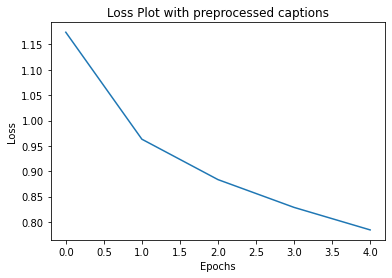

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot with preprocessed captions')
plt.show()

#####Backup

In [ ]:
import joblib
joblib.dump(encoder, './models/preprocessed/encoder.pkl')
joblib.dump(decoder, './models/preprocessed/decoder.pkl')

####Evaluation

---



Αυτή τη φορά το παραγώμενο caption είναι λιγότερο ακριβές σε σχέση με το real caption, ωστόσο κάτι τέτοιο μπορεί να οφείλεται και στην συγκεκριμένη εικόνα μιας και βλέπουμε ότι ακόμα και οι άνθρωποι που δημιούργησαν το real caption δεν αντιλήφθηκαν πλήρως τι απεικονίζει η εικόνα.

Real Caption: <start> a shirt girl wearing or horse members drawings people upper a vegetables on front holds <end>
Prediction Caption: <start> a shirt walk three is dives while motion the working <end>


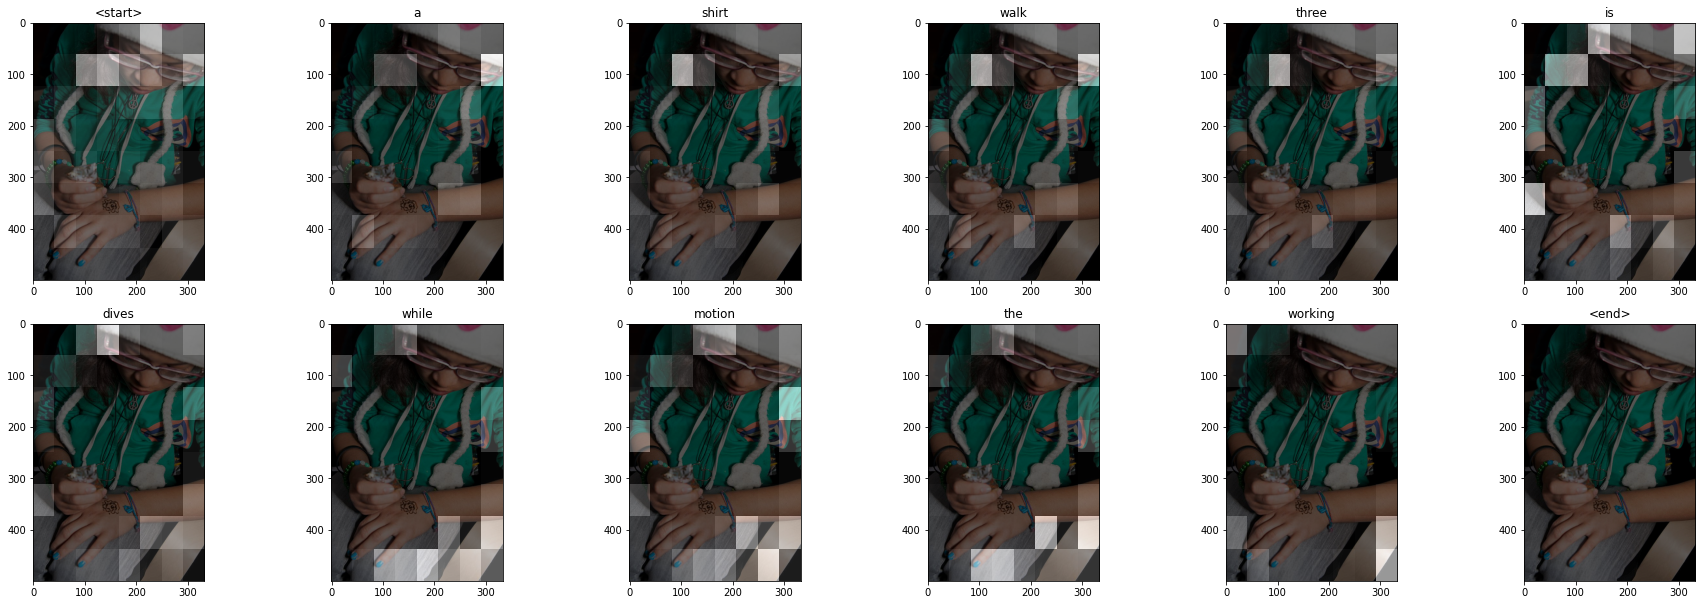

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image, encoder, decoder)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

####Validation

---



In [ ]:
hypotheses = []
references = []

for img in tqdm(img_name_val_keys):
  refs = img_to_cap_vector[img]
  refs = [[tf.compat.as_text(index_to_word(i).numpy()) for i in lst if i not in [0]] for lst in refs]
  references.append(refs)

  hyp, _ = evaluate(img, encoder, decoder)
  hypotheses.append(hyp)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [38:27<00:00,  1.92s/it]


#####Backup

In [ ]:
joblib.dump(hypotheses, './models/bleu/preprocessed/hypotheses.pkl')
joblib.dump(references, './models/bleu/preprocessed/references.pkl')

#####Bleu Scores

In [ ]:
hypotheses = joblib.load('./models/bleu/preprocessed/hypotheses.pkl')
references = joblib.load('./models/bleu/preprocessed/references.pkl')

Σχετικά με τα bleu scores, παρατηρούμε ότι έχουν μειωθεί ελάχιστα σε σχέση με το baseline. Κάτι τέτοιο πιθανόν να οφείλεται στο γεγονός ότι με την αύξηση του λεξιλογίου, χρησιμοποιούνται μεν περισσότερες διαφορετικές λέξεις για την παραγωγή των captions ωστόσο κάτι τέτοιο εισάγει και έναν παράγοντα ασάφειας κάτι που μπορεί να επιδράσει στα σκορ (παραδείγματος χάρη μπορεί μια εικόνα να απεικονίζει ένα ρυάκι, οι άνθρωποι που δημιούργησαν τα real captions να το ονόμασαν ποτάμι και το δικό μας μοντέλο να χρησιμοποιεί την ονομασία ρυάκι οπότε το bleu score να το θεωρήσει λάθος).

In [ ]:
maxbleu = 0
maxi = None

for i in range(len(references)):
  tmp = sentence_bleu(references[i], hypotheses[i])

  if tmp > maxbleu:
    maxbleu = tmp
    maxi = i

In [ ]:
print("Real Captions:")
for i in references[maxi]:
  print(" ".join(i))

print()
print("Predicted Caption:")
print(" ".join(hypotheses[maxi]))

print("Highest Sentence Bleu Score:", sentence_bleu(references[maxi], hypotheses[maxi]))

Real Captions:
<start> a helmet player in a eating with a baseball gray and book smiling is stool the from with his smoke <end>
<start> a [UNK] pen could a helmet player stool a from middle a pool <end>
<start> a helmet player stool a make drinking <end>
<start> a helmet player stool a from <end>
<start> a helmet player participating helmet <end>

Predicted Caption:
<start> a helmet player in a glow <end>
Highest Sentence Bleu Score: 0.788238465735608


In [ ]:
result = corpus_bleu(references, hypotheses)
print("Corpus Bleu Score =", result)

Corpus Bleu Score = 0.09351821580682365


###Encoder

Ο αριθμός της ομάδας μας ισούται με 100 επομένως μας ζητήθηκε να δοκιμάσουμε να χρησιμοποιήσουμε ως encoder το NASNetLarge πέρα από το InceptionV3.

In [ ]:
def load_image(image_path):
  img = tf.io.read_file('./image_dir/' + image_path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.keras.layers.Resizing(331, 331)(img)

  img = tf.keras.applications.nasnet.preprocess_input(img)
  return img, image_path

Αρχικοποιούμε το μοντέλο με βάση τις κατάλληλες παραμέτρους. Παρατηρούμε ότι στην παράμετρο include_top βάζουμε False μιας και αναφέρεται στο fully connected layer το οποίο εισάγουμε στην αντίστοιχη κλάση και όχι εδώ. Ακόμα, επειδή ορίσαμε να χρησιμοποιηθούν ως weights το σύνολο "imagenet" τότε με βάση το documentation κάναμε resize στις εικόνες ώστε να έχουν το κατάλληλο μέγεθος (331, 331, 3). Τέλος, προσέχουμε ότι έχει χρησιμοποιηθεί ως συνάρτηση προεπεξεργασίας η `tf.keras.applications.nasnet.preprocess_input` αντί της `tf.keras.applications.inception_c3.preprocess_input` που χρησιμοποιούσαμε πριν.

In [ ]:
from tqdm import tqdm
nasnet_image_model = tf.keras.applications.NASNetLarge(
    input_shape=None,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
)
nasnet_new_input = nasnet_image_model.input
nasnet_hidden_layer = nasnet_image_model.layers[-1].output

nasnet_image_features_extract_model = tf.keras.Model(nasnet_new_input, nasnet_hidden_layer)

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = nasnet_image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save("./nasnet/" + path_of_feature, bf.numpy())

In [ ]:
# !cp ./*.npy ./neural_networks_nekt/npy_data_NASNetLarge

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
random.seed(200)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(23615, 23615, 5892, 5892)

Σε αυτό το σημείο προσέξαμε ότι το features_shape έπρεπε να πάρει την τιμή 4032 και το `attention_featutes_shape` την τιμή 121 προκειμένου να είναι συμβατά με το νέο μοντέλο.

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from NASNetLarge is (121, 4032)
# These two variables represent that vector shape
features_shape = 4032
attention_features_shape = 121

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  # img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  img_name = img_name.decode('utf-8')
  img_tensor = np.load( './nasnet/' + img_name.split("/")[-1] + '.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
random.seed(300)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Αρχικοποιούμε τους encoder, decoder:

In [ ]:
encoder_nasnet = CNN_Encoder(embedding_dim)
decoder_nasnet = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

####Training

---



In [ ]:
checkpoint_path = "./checkpoints/nasnet/"
ckpt = tf.train.Checkpoint(encoder=encoder_nasnet,
                           decoder=decoder_nasnet,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target, encoder, decoder):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, encoder_nasnet, decoder_nasnet)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 3.9167
Epoch 1 Batch 100 Loss 2.1120
Epoch 1 Batch 200 Loss 2.1371
Epoch 1 Batch 300 Loss 2.2055
Epoch 1 Loss 2.110901
Time taken for 1 epoch 576.92 sec

Epoch 2 Batch 0 Loss 1.7628
Epoch 2 Batch 100 Loss 1.7700
Epoch 2 Batch 200 Loss 1.6750
Epoch 2 Batch 300 Loss 1.6490
Epoch 2 Loss 1.770824
Time taken for 1 epoch 489.65 sec

Epoch 3 Batch 0 Loss 1.6087
Epoch 3 Batch 100 Loss 1.5383
Epoch 3 Batch 200 Loss 1.6339
Epoch 3 Batch 300 Loss 1.5874
Epoch 3 Loss 1.665843
Time taken for 1 epoch 388.28 sec

Epoch 4 Batch 0 Loss 1.4896
Epoch 4 Batch 100 Loss 1.4932
Epoch 4 Batch 200 Loss 1.5709
Epoch 4 Batch 300 Loss 1.5677
Epoch 4 Loss 1.585717
Time taken for 1 epoch 452.93 sec

Epoch 5 Batch 0 Loss 1.5239
Epoch 5 Batch 100 Loss 1.5000
Epoch 5 Batch 200 Loss 1.5335
Epoch 5 Batch 300 Loss 1.4386
Epoch 5 Loss 1.508729
Time taken for 1 epoch 404.19 sec



##### Loss plot

Με βάση το παρακάτω loss plot παρατηρούμε ότι σε αυτή την περίπτωση ξεκινάει η εκπαίδευση με αρκετά μεγάλο loss (της τάξης του 2) το οποίο σταδιακά μειώνεται και φτάνει μέχρι το 1.5, τιμή η οποία πάλι θεωρείται μεγάλη, ωστόσο δεν μπορούμε να εξάγουμε ακριβή συμπεράσματα μιας και είναι λίγες οι εποχές εκπαίδευσης. Κάτι άλλο το οποίο παρατηρήσαμε είναι ότι η μείωση του loss δεν είναι ομοιόμορφη μιας και στο τέλος της 1ης εποχής μειώνεται με γρήγορο ρυθμό και από εκεί και μετά με πιο αργό ρυθμό. Σχετικά με τον χρόνο εκπαίδευσης βλέπουμε ότι με τον συγκεκριμένο encoder χρειάζεται πλέον πολύ περισσότερο χρονο για να εκπαιδευτεί το νευρωνικό μιας και χρειάζεται περίπου 7.5 λεπτά/εποχή.

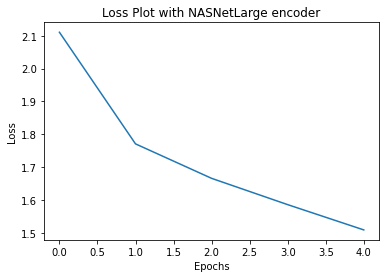

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot with NASNetLarge encoder')
plt.show()

#### Evaluation

Ξαναορίζουμε την συνάρτηση evaluate καθώς πλέον χρησιμοποιουμε την `nasnet_image_features_extract_model`

In [ ]:
def evaluate(image,encoder,decoder):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = nasnet_image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = ['<start>']

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open('./image_dir/' + image))

    fig = plt.figure(figsize=(25, 25))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Εδώ παρατηρούμε πιο μικρό σε μήκος prediction caption το οποίο δεν είναι απαραίτητα αρνητικό και βλέπουμε ότι αναγνωρίζει ότι υπάρχει ένα building και ένα πλήθος ανθρώπων, ωστόσο αποτυγχάνει να εντοπίσει το κόκκινο χρώμα το οποίο είναι σημαντικό στοιχείο της εικόνας.

Real Caption: <start> a person wearing red is at the forefront of an underdeveloped city with man hanging cloths visible <end>
Prediction Caption: <start> a group of the building in a members <end>


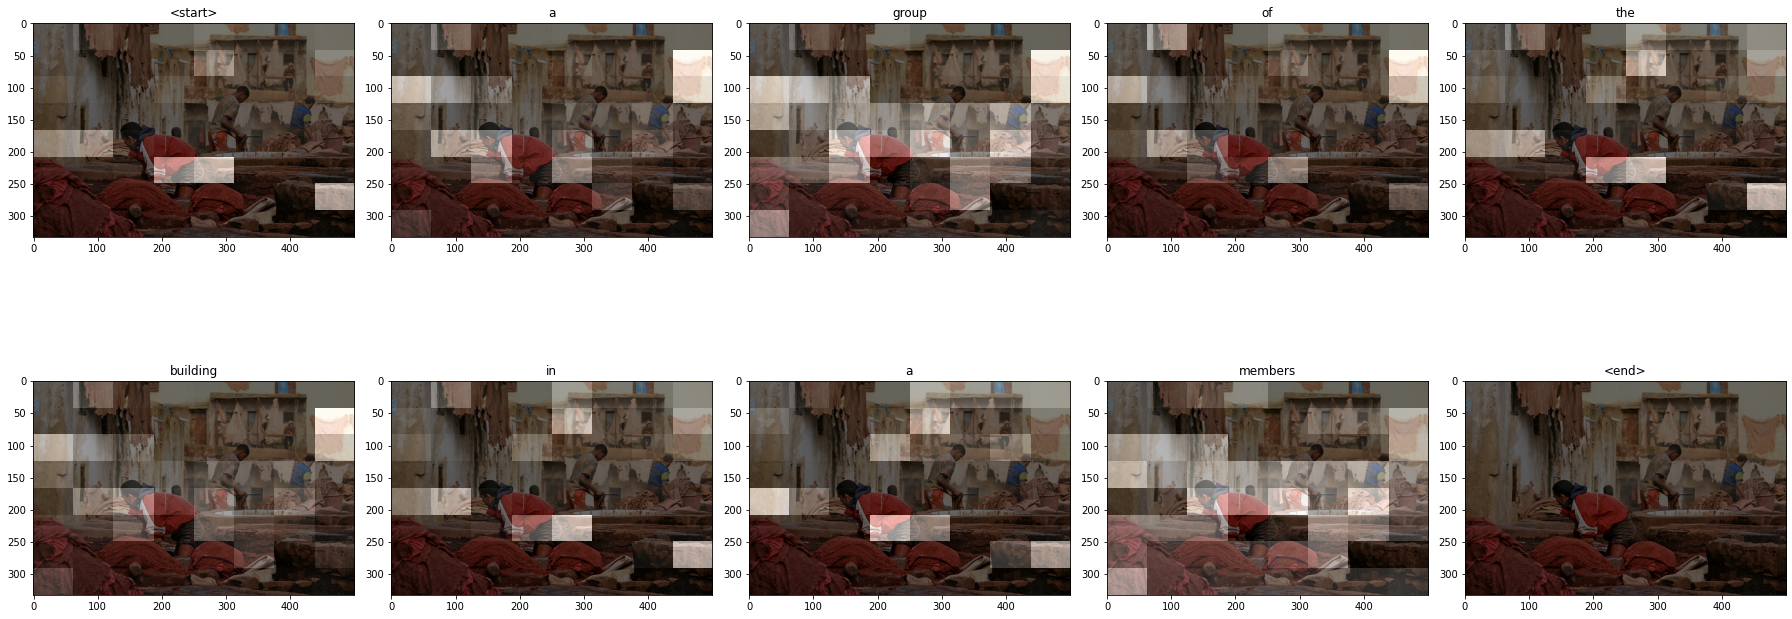

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image, encoder_nasnet, decoder_nasnet)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

##### Backup

---




Στο συγκεκριμένο σημείο κρατάμε backup των αρχείων μας για μεταγενέστερη χρήση:

In [ ]:
import joblib
joblib.dump(encoder_nasnet, './models/nasnet/encoder_nasnet.pkl')
joblib.dump(decoder_nasnet, './models/nasnet/decoder_nasnet.pkl')

####Validation

---



In [ ]:
hypotheses = []
references = []

for img in tqdm(img_name_val_keys):
  refs = img_to_cap_vector[img]
  refs = [[tf.compat.as_text(index_to_word(i).numpy()) for i in lst if i not in [0]] for lst in refs]
  references.append(refs)

  hyp, _ = evaluate(img, encoder_nasnet, decoder_nasnet)
  hypotheses.append(hyp)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [40:57<00:00,  2.05s/it]


#####Backup

In [ ]:
joblib.dump(hypotheses, './models/bleu/nasnet/hypotheses.pkl')
joblib.dump(references, './models/bleu/nasnet/references.pkl')

#####Bleu Scores

Σε αυτό το σημείο παρατηρούμε ότι το bleu score έχει μειωθεί σε σχέση με πριν, κάτι το οποίο μας οδηγεί στο συμπέρασμα ότι η αλλαγή του encoder για το συγκεκριμένο dataset μπορεί να μην αποτελεί βελτίωση.

In [ ]:
hypotheses = joblib.load('./models/bleu/nasnet/hypotheses.pkl')
references = joblib.load('./models/bleu/nasnet/references.pkl')

In [ ]:
maxbleu = 0
maxi = None

for i in range(len(references)):
  tmp = sentence_bleu(references[i], hypotheses[i])

  if tmp > maxbleu:
    maxbleu = tmp
    maxi = i

In [ ]:
print("Real Captions:")
for i in references[maxi]:
  print(" ".join(i))

print()
print("Predicted Caption:")
print(" ".join(hypotheses[maxi]))

print("Highest Sentence Bleu Score:", sentence_bleu(references[maxi], hypotheses[maxi]))

Real Captions:
<start> a woman in a blue robed garment talking to a merchant sitting under an umbrella near a fruit stand <end>
<start> a woman in a blue talks with a fruit salesman on the street <end>
<start> a woman talks to a man at the market <end>
<start> a figure of an oriental man sits on a wall in front of some white apartment buildings <end>
<start> a man with a blue shirt and a straw hat near a creek is smoking a cigarette <end>

Predicted Caption:
a man in a blue shirt and solution into a tree <end>
Highest Sentence Bleu Score: 0.45991853272822636


In [ ]:
result = corpus_bleu(references, hypotheses)
print("Corpus Bleu Score =", result)

Corpus Bleu Score = 0.05440448836106045


###Embeddings

Στο σημείο αυτό χρησιμοποιήσαμε έτοιμα embeddings με transfer learning προκειμένου να μειώσουμε το πλήθος των βαρών προς εκπαίδευση. Χρησιμοποιήσαμε το αρχείο `glove.6B.200d.txt` που χρησιμοποιεί embeddings μήκους 200 ώστε να μην μαθαίνονται τα embeddings κατά την εκπαίδευση του μοντέλου.

####Λήψη κατάλληλων αρχείων

In [ ]:
import pathlib

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
path_to_glove_file = "./glove.6B.200d.txt"
embeddings_index = {} 

with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [ ]:
voc = tokenizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc)
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 4032
attention_features_shape = 121

####Ορισμός συναρτήσεων/κλάσεων

Πειράξαμε τον decoder προσθέτοντας ένα embedding_layer το οποίο έχει οριστεί όπως φαίνεται παρακάτω:

In [ ]:
from tensorflow import keras
from keras.layers import Embedding
from keras import layers

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable = False,
)

In [ ]:
class Embeddings_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Embeddings_Decoder, self).__init__()
    self.units = units

    self.embedding = embedding_layer
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
@tf.function
def train_step(img_tensor, target, encoder, decoder):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
embeddings_encoder = CNN_Encoder(embedding_dim)
embeddings_decoder = Embeddings_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

####Training 

---



In [ ]:
checkpoint_path = "./checkpoints/embeddings/"
ckpt = tf.train.Checkpoint(encoder = embeddings_encoder,
                           decoder = embeddings_decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
embd_loss_plot = []

In [ ]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, embeddings_encoder, embeddings_decoder)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    embd_loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 3.9536
Epoch 1 Batch 100 Loss 2.0316
Epoch 1 Batch 200 Loss 1.8424
Epoch 1 Batch 300 Loss 1.7873
Epoch 1 Loss 2.026765
Time taken for 1 epoch 432.42 sec

Epoch 2 Batch 0 Loss 1.8449
Epoch 2 Batch 100 Loss 1.5601
Epoch 2 Batch 200 Loss 1.5508
Epoch 2 Batch 300 Loss 1.5864
Epoch 2 Loss 1.616428
Time taken for 1 epoch 257.86 sec

Epoch 3 Batch 0 Loss 1.6215
Epoch 3 Batch 100 Loss 1.4217
Epoch 3 Batch 200 Loss 1.4457
Epoch 3 Batch 300 Loss 1.2515
Epoch 3 Loss 1.445443
Time taken for 1 epoch 277.61 sec

Epoch 4 Batch 0 Loss 1.3597
Epoch 4 Batch 100 Loss 1.2591
Epoch 4 Batch 200 Loss 1.4225
Epoch 4 Batch 300 Loss 1.2651
Epoch 4 Loss 1.319835
Time taken for 1 epoch 252.35 sec

Epoch 5 Batch 0 Loss 1.2746
Epoch 5 Batch 100 Loss 1.2666
Epoch 5 Batch 200 Loss 1.1548
Epoch 5 Batch 300 Loss 1.1271
Epoch 5 Loss 1.220015
Time taken for 1 epoch 242.08 sec



#####Loss Plot

Τώρα παρατηρούμε ότι η εκπαίδευση ξεκινάει με μικρότερο loss από ότι στην προηγούμενη δοκιμή και τελειώνει την εκπαίδευση πάλι με μικρότερο loss, κάτι το οποίο μας κάνει να αντιληφθούμε ότι έχει υπάρξει μία βελτίωση με την χρήση των έτοιμων εμφυτευμάτων. Ακόμα, έχει υπάρξει μεγάλη βελτίωση και ως προς τους χρόνους εκπαίδευσης καθώς πλέον είναι περίπου 4.5 λεπτά/εποχή.

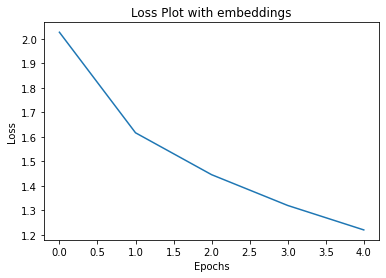

In [ ]:
plt.plot(embd_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot with embeddings')
plt.show()

####Evaluation

Σχετικά με το caption βλέπουμε ότι παρότι έχει ανιχνεύσει τα βασικά σημεία της εικόνας, το λεξιλόγιο που χρησιμοποιεί είναι αρκετά διαφορετικό από αυτό του real caption, κάτι το οποίο θα έχει επίδραση στο bleu score αν συμβαίνει σε πολλές εικόνες.

Real Caption: <start> a man in a green shirt trims the grass in a riding mower <end>
Prediction Caption: <start> a man in camouflage is operating to fall at the dirt <end>


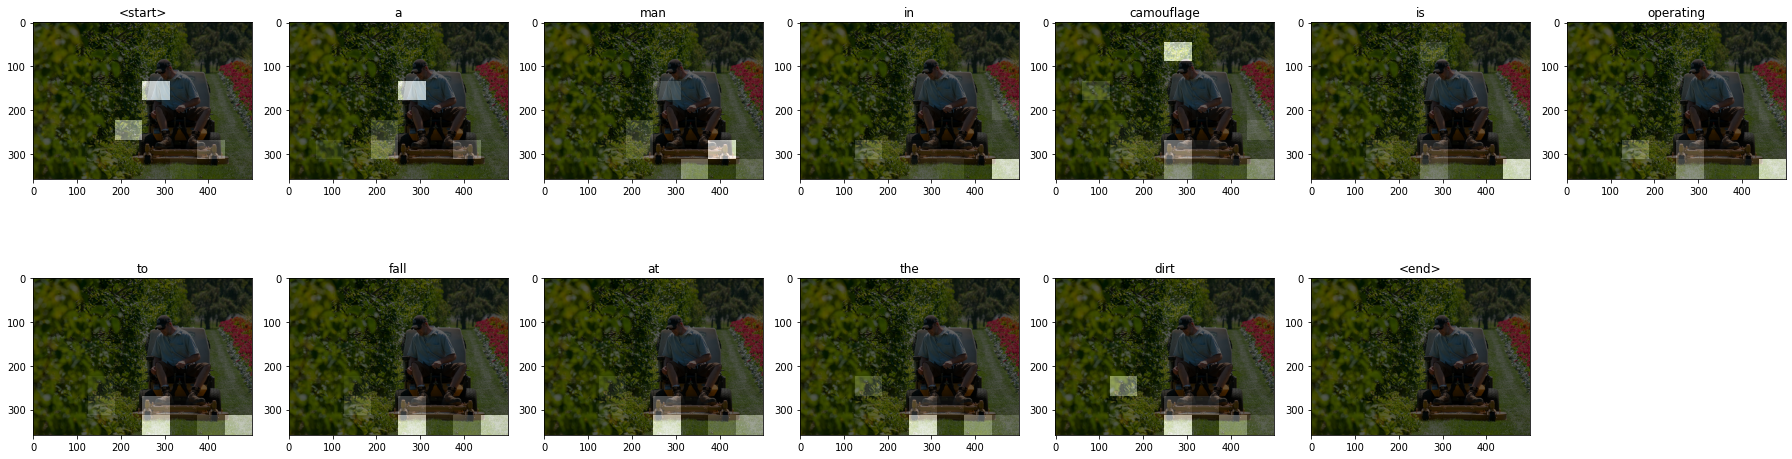

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image, embeddings_encoder, embeddings_decoder)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

##### Backup

---




Στο συγκεκριμένο σημείο κρατάμε backup των αρχείων μας για μεταγενέστερη χρήση:

In [ ]:
joblib.dump(embeddings_decoder, './models/embeddings/embeddings_decoder.pkl')

####Validation

---



In [ ]:
hypotheses = []
references = []

for img in tqdm(img_name_val_keys):
  refs = img_to_cap_vector[img]
  refs = [[tf.compat.as_text(index_to_word(i).numpy()) for i in lst if i not in [0]] for lst in refs]
  references.append(refs)

  hyp, _ = evaluate(img, embeddings_encoder, embeddings_decoder)
  hypotheses.append(hyp)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [38:19<00:00,  1.92s/it]


#####Backup

In [ ]:
joblib.dump(hypotheses, './models/bleu/embeddings/hypotheses.pkl')
joblib.dump(references, './models/bleu/embeddings/references.pkl')

#####Bleu Scores

In [ ]:
hypotheses = joblib.load('./models/bleu/embeddings/hypotheses.pkl')
references = joblib.load('./models/bleu/embeddings/references.pkl')

Το corpus bleu σε αυτή την περίπτωση έχει αυξηθεί σε σχέση με το προηγούμενο στάδιο επομένως έχουμε μία εμφανή βελτίωση με την χρήση έτοιμων εμφυτευμάτων.

In [ ]:
maxbleu = 0
maxi = None

for i in range(len(references)):
  tmp = sentence_bleu(references[i], hypotheses[i])

  if tmp > maxbleu:
    maxbleu = tmp
    maxi = i

In [ ]:
print("Real Captions:")
for i in references[maxi]:
  print(" ".join(i))

print()
print("Predicted Caption:")
print(" ".join(hypotheses[maxi]))

print("Highest Sentence Bleu Score:", sentence_bleu(references[maxi], hypotheses[maxi]))

Real Captions:
<start> a saddle [UNK] rider gets lifted out of the saddle but keeps his [UNK] during his ride <end>
<start> a man wearing a white shire shirt and hate is riding a bucking horse in a rodeo <end>
<start> a cowboy is riding a bull on a rodeo and is having trouble staying upright <end>
<start> a cowboy riding on the back of a bronco in a competition <end>
<start> cowboy at a rodeo riding a horse <end>

Predicted Caption:
<start> a man wearing a cowboy gets [UNK] <end>
Highest Sentence Bleu Score: 0.6417688319882853


In [ ]:
result = corpus_bleu(references, hypotheses)
print("Corpus Bleu Score =", result)

Corpus Bleu Score = 0.09534807407675236


###Regularization

Προκειμένου το νευρωνικό δίκτυο να έχει καλή απόδοση, χρειάζεται να είναι αρκετά "βαθύ" δηλαδή να έχει έναν επαρκή αριθμό επιπέδων νευρώνων. Κάτι τέτοιο ωστόσο καθιστά το νευρωνικό ευαίσθητο σε overfitting το οποίο οδηγεί σε αποτυχία ως προς την γενίκευση. Γι'αυτό τον λόγο χρησιμοποιούνται διάφορες τεχνικές ομαλοποίησης μία εκ των οποίων είναι η προσθήκη επιπέδων Dropout. Με αυτή την μέθοδο, επιλέγεται τυχαία ένας αριθμός εξόδων νευρώνων οι οποίες αγνοούνται με βάση κάποια ορισμένη από τον χρήστη πιθανότητα. Εμείς επιλέξαμε με βάση πειραματισμούς ότι η κατάλληλη πιθανότητα ισούται με 0.2.

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        #self.dropout = tf.keras.layers.Dropout(0.2)

    def call(self, x):
        x = self.fc(x)
        #x = self.dropout(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class Embeddings_Decoder_Reg(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Embeddings_Decoder_Reg, self).__init__()
    self.units = units

    self.embedding = embedding_layer
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.dropout = tf.keras.layers.Dropout(0.2)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    x = self.dropout(x)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
@tf.function
def train_step(img_tensor, target, encoder, decoder):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
encoder_reg = CNN_Encoder(embedding_dim)
decoder_reg = Embeddings_Decoder_Reg(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
checkpoint_path = "./checkpoints/reg/"
ckpt = tf.train.Checkpoint(encoder=encoder_reg,
                           decoder=decoder_reg,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

####Training

---

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, encoder_reg, decoder_reg)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 3.8661
Epoch 1 Batch 100 Loss 2.3052
Epoch 1 Batch 200 Loss 1.8582
Epoch 1 Batch 300 Loss 1.6993
Epoch 1 Loss 2.018775
Time taken for 1 epoch 401.80 sec

Epoch 2 Batch 0 Loss 1.8726
Epoch 2 Batch 100 Loss 1.5251
Epoch 2 Batch 200 Loss 1.6507
Epoch 2 Batch 300 Loss 1.5959
Epoch 2 Loss 1.620859
Time taken for 1 epoch 240.16 sec

Epoch 3 Batch 0 Loss 1.5926
Epoch 3 Batch 100 Loss 1.4704
Epoch 3 Batch 200 Loss 1.5815
Epoch 3 Batch 300 Loss 1.3430
Epoch 3 Loss 1.452562
Time taken for 1 epoch 245.69 sec

Epoch 4 Batch 0 Loss 1.4074
Epoch 4 Batch 100 Loss 1.3947
Epoch 4 Batch 200 Loss 1.3691
Epoch 4 Batch 300 Loss 1.4402
Epoch 4 Loss 1.327517
Time taken for 1 epoch 239.57 sec

Epoch 5 Batch 0 Loss 1.2813
Epoch 5 Batch 100 Loss 1.2016
Epoch 5 Batch 200 Loss 1.1841
Epoch 5 Batch 300 Loss 1.1923
Epoch 5 Loss 1.229441
Time taken for 1 epoch 223.38 sec



##### Loss plot

Σε αυτό το σημείο παρατηρούμε ότι το loss είναι ελάχιστα μεγαλύτερο σε κάθε εποχή από ότι στο προηγούμενο βήμα. Από την άλλη, ο χρόνος εκπαίδευσης έχει μειωθεί και είναι περίπου 3.5 λεπτά/εποχή (αν εξαιρέσουμε την πρώτη εποχή όπου όπως έχει προαναφερθεί χρειάζεται περισσότερο χρόνο).

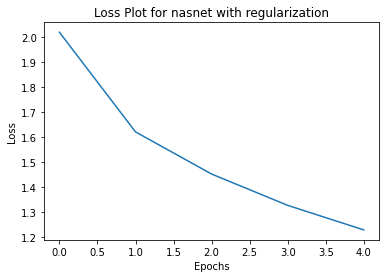

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot for nasnet with regularization')
plt.show()

#### Evaluation

Βλέπουμε ότι το captions που παράγεται αντικατοπτρίζει την ουσία της εικόνας αλλα εστιάζει σε διαφορετικό κομμάτι από ότι το real caption (το real caption αναφέρεται στις δύο γυναίκες ενώ το prediction caption εστιάζει στην μία γυναίκα μόνο).

Real Caption: <start> two women one holding a beer bottle and smiling the other holding a blue cup and looking down <end>
Prediction Caption: <start> a shorthaired brunette woman wearing sunglasses is talking <end>


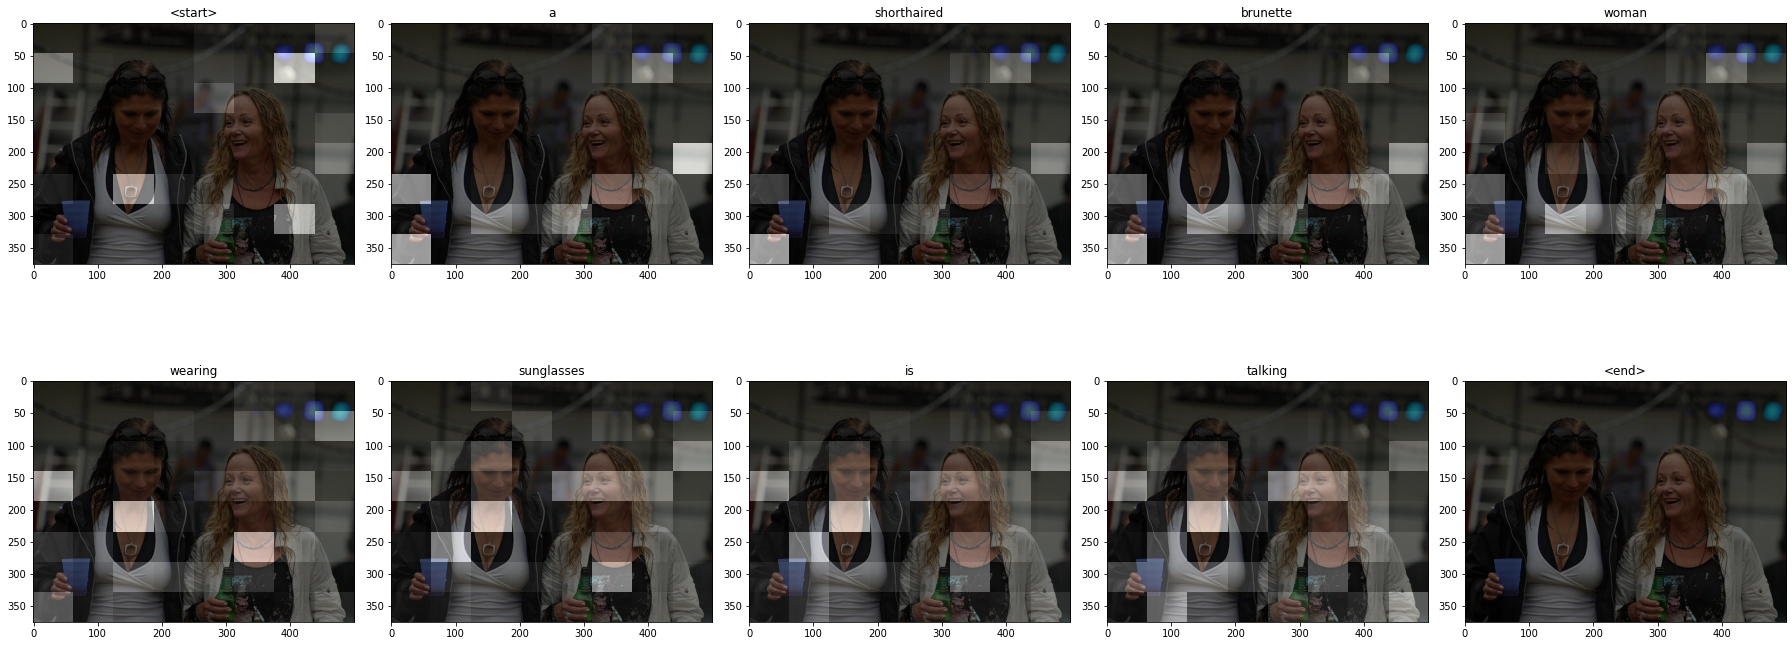

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image, encoder_reg, decoder_reg)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

##### Backup

---




Στο συγκεκριμένο σημείο κρατάμε backup των αρχείων μας για μεταγενέστερη χρήση:

In [ ]:
import joblib
joblib.dump(encoder_reg, './models/reg/encoder_reg.pkl')
joblib.dump(decoder_reg, './models/reg/decoder_reg.pkl')

####Validation

---



In [ ]:
hypotheses = []
references = []

for img in tqdm(img_name_val_keys):
  refs = img_to_cap_vector[img]
  refs = [[tf.compat.as_text(index_to_word(i).numpy()) for i in lst if i not in [0]] for lst in refs]
  references.append(refs)

  hyp, _ = evaluate(img, encoder_reg, decoder_reg)
  hypotheses.append(hyp)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [35:58<00:00,  1.80s/it]


#####Backup

In [ ]:
joblib.dump(hypotheses, './models/bleu/reg/hypotheses.pkl')
joblib.dump(references, './models/bleu/reg/references.pkl')

#####Bleu Scores

In [ ]:
hypotheses = joblib.load('./models/bleu/reg/hypotheses.pkl')
references = joblib.load('./models/bleu/reg/references.pkl')

Παρατηρούμε μία ελάχιστη μείωση στο bleu score, όχι όμως τόσο μεγάλη ώστε να κρίνεται σημαντική. Περαιτέρω βελτιώσεις ίσως θα μπορούσαν να προκύψουν εάν αλλάζαμε την πιθανότητα του dropout layer ωστόσο κάτι τέτοιο θα είχε μεγάλο υπολογιστικό κόστος και μικρή πιθανότατα βελτίωση.

In [ ]:
maxbleu = 0
maxi = None

for i in range(len(references)):
  tmp = sentence_bleu(references[i], hypotheses[i])

  if tmp > maxbleu:
    maxbleu = tmp
    maxi = i

In [ ]:
print("Real Captions:")
for i in references[maxi]:
  print(" ".join(i))

print()
print("Predicted Caption:")
print(" ".join(hypotheses[maxi]))

print("Highest Sentence Bleu Score:", sentence_bleu(references[maxi], hypotheses[maxi]))

Real Captions:
<start> a man in an orange vest and blue hat smiles next to a large piece of equipment <end>
<start> a man with orange vest and blue cap standing next to electronic equipment <end>
<start> a man in a safety vest is posing in front of some technical equipment <end>
<start> a man demonstrating how a computer system works <end>
<start> working in a nice factory <end>

Predicted Caption:
<start> a man in an orange vest works <end>
Highest Sentence Bleu Score: 0.7626542259566731


In [ ]:
result = corpus_bleu(references, hypotheses)
print("Corpus Bleu Score =", result)

Corpus Bleu Score = 0.08699185954997941


###Decoder

Στην συνέχεια, μας ζητήθηκε να πειραματισμούμε με το πλήθος και το είδος των μονάδων στην επίδοση. Στα προηγούμενα βήματα χρησιμοποιούσαμε 512 μονάδες GRU επομένως σε αυτό το βήμα δοκιμάζουμε 229 GRU, 700 GRU και 512 LSTM.

#### Units = 229 GRU

In [ ]:
@tf.function
def train_step(img_tensor, target, encoder, decoder):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
units_1 = 229

In [ ]:
encoder_reg = CNN_Encoder(embedding_dim)
decoder_units_1 = Embeddings_Decoder_Reg(embedding_dim, units_1, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
checkpoint_path = "./checkpoints/units/units_11"
ckpt = tf.train.Checkpoint(encoder=encoder_reg,
                           decoder=decoder_units_1,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

#####Training

---

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, encoder_reg, decoder_units_1)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 3.7199
Epoch 1 Batch 100 Loss 2.2856
Epoch 1 Batch 200 Loss 2.1111
Epoch 1 Batch 300 Loss 1.7622
Epoch 1 Loss 0.540383
Time taken for 1 epoch 303.75 sec

Epoch 2 Batch 0 Loss 1.8772
Epoch 2 Batch 100 Loss 1.6135
Epoch 2 Batch 200 Loss 1.6106
Epoch 2 Batch 300 Loss 1.5593
Epoch 2 Loss 0.426568
Time taken for 1 epoch 216.05 sec

Epoch 3 Batch 0 Loss 1.6971
Epoch 3 Batch 100 Loss 1.4634
Epoch 3 Batch 200 Loss 1.5319
Epoch 3 Batch 300 Loss 1.4723
Epoch 3 Loss 0.382676
Time taken for 1 epoch 214.87 sec

Epoch 4 Batch 0 Loss 1.5254
Epoch 4 Batch 100 Loss 1.3497
Epoch 4 Batch 200 Loss 1.4617
Epoch 4 Batch 300 Loss 1.3880
Epoch 4 Loss 0.352520
Time taken for 1 epoch 219.48 sec

Epoch 5 Batch 0 Loss 1.4226
Epoch 5 Batch 100 Loss 1.2111
Epoch 5 Batch 200 Loss 1.2930
Epoch 5 Batch 300 Loss 1.2587
Epoch 5 Loss 0.328985
Time taken for 1 epoch 222.48 sec



###### Loss plot

Με χρήση 229 GRU παρατηρούμε ότι το loss είναι αρκετά μικρότερο σε σχέση με τα 512 που είχαμε πριν και συνολικά απαιτεί λιγότερο χρόνο εκπαίδευσης. Επίσης βλέπουμε ότι το plot στις 3 πρώτες εποχές αλλάζει κλίση από πολυ μεγάλη (1η εποχή) σε μεσαία (2η εποχή) και τέλος σε μικρότερη (3η εποχή).

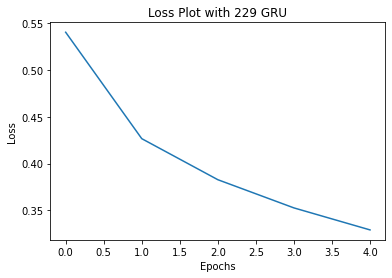

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot with 229 GRU')
plt.show()

##### Evaluation

Το caption που παράγεται φαίνεται εντελώς διαφορετικό σε σχέση με το real caption επομένως η συγκεκριμένη αλλαγή πιθανόν να είναι κακή προς το νευρωνικό.

Real Caption: <start> boy in cowboy hat and boy in baseball cap on the porch outside of a restaurant <end>
Prediction Caption: <start> trainer with a man in a black and black and blue water gloves and a fountain suit and daughter is wearing safety jacket is kneeling on wooden rooftop <end>


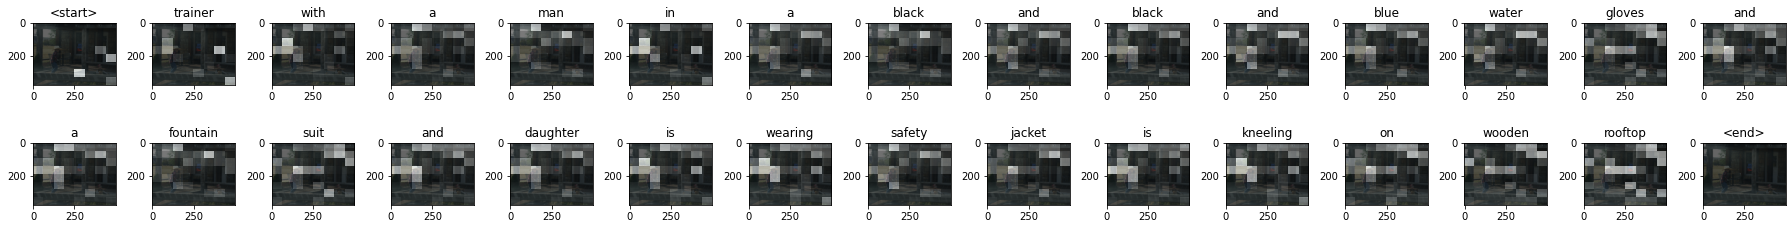

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image, encoder_reg, decoder_units_1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

###### Backup

---




Στο συγκεκριμένο σημείο κρατάμε backup των αρχείων μας για μεταγενέστερη χρήση:

In [ ]:
import joblib
joblib.dump(decoder_units_1, './models/units/decoder_units_1.pkl')

#####Validation

---



In [ ]:
hypotheses = []
references = []

for img in img_name_val_keys:
  refs = img_to_cap_vector[img]
  refs = [[tf.compat.as_text(index_to_word(i).numpy()) for i in lst if i not in [0]] for lst in refs]
  references.append(refs)

  hyp, _ = evaluate(img, encoder_reg, decoder_units_1)
  hypotheses.append(hyp)

######Backup

In [ ]:
joblib.dump(hypotheses, './models/bleu/units/units_1/hypotheses.pkl')
joblib.dump(references, './models/bleu/units/units_1/references.pkl')

######Bleu Scores

In [ ]:
hypotheses = joblib.load('./models/bleu/units/units_1/hypotheses.pkl')
references = joblib.load('./models/bleu/units/units_1/references.pkl')

Με βάση τα παρακάτω σκορ δεν βλέπουμε κάποια μεγάλη αλλαγή σε σχέση με πριν άρα η συγκεκριμένη αλλαγή δεν ωφελεί το νευρωνικό και άρα δεν θα χρησιμοποιηθεί στο ολοκληρωμένο τελικό μοντέλο.

In [ ]:
maxbleu = 0
maxi = None

for i in range(len(references)):
  tmp = sentence_bleu(references[i], hypotheses[i])

  if tmp > maxbleu:
    maxbleu = tmp
    maxi = i

In [ ]:
print("Real Captions:")
for i in references[maxi]:
  print(" ".join(i))

print()
print("Predicted Caption:")
print(" ".join(hypotheses[maxi]))

print("Highest Sentence Bleu Score:", sentence_bleu(references[maxi], hypotheses[maxi]))

Real Captions:
<start> a yellow and black dog looking in the same direction standing in some brush <end>
<start> a light brown dog and a black and brown dog are in some dry brush <end>
<start> a brown dog and black dog are [UNK] in some [UNK] <end>
<start> one tan dog with a stick and one mostly black dog <end>
<start> two dogs playing outside <end>

Predicted Caption:
<start> a black and brown dog <end>
Highest Sentence Bleu Score: 1.0


In [ ]:
result = corpus_bleu(references, hypotheses)
print("Corpus Bleu Score =", result)

Corpus Bleu Score = 0.08640701893165045


#### Units = 700 GRU

Στο συγκεκριμένο σημείο προσπαθήσαμε να αυξήσουμε τον αριθμό των GRU units. Δοκιμάσαμε διάφορες μεγάλες τιμές (800, 900, 1000 κλπ) αλλά παρατηρήσαμε ότι το πρόγραμμα έσκαγε λόγω έλλειψης χώρου επομένως κρατήσαμε σαν τιμή το 700.

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 16
BUFFER_SIZE = 1000
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 4032
attention_features_shape = 121

In [ ]:
@tf.function
def train_step(img_tensor, target, encoder, decoder):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
units_2 = 700

In [ ]:
encoder_reg = CNN_Encoder(embedding_dim)
decoder_units_2 = Embeddings_Decoder_Reg(embedding_dim, units_2, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
checkpoint_path = "./checkpoints/units/units_2"
ckpt = tf.train.Checkpoint(encoder=encoder_reg,
                           decoder=decoder_units_2,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

#####Training

---

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, encoder_reg, decoder_units_2)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 3.9134
Epoch 1 Batch 100 Loss 1.9969
Epoch 1 Batch 200 Loss 1.7323
Epoch 1 Batch 300 Loss 1.6945
Epoch 1 Loss 0.481674
Time taken for 1 epoch 315.97 sec

Epoch 2 Batch 0 Loss 1.6900
Epoch 2 Batch 100 Loss 1.5777
Epoch 2 Batch 200 Loss 1.5012
Epoch 2 Batch 300 Loss 1.5425
Epoch 2 Loss 0.386265
Time taken for 1 epoch 235.29 sec

Epoch 3 Batch 0 Loss 1.5110
Epoch 3 Batch 100 Loss 1.3737
Epoch 3 Batch 200 Loss 1.4773
Epoch 3 Batch 300 Loss 1.5066
Epoch 3 Loss 0.344381
Time taken for 1 epoch 241.53 sec

Epoch 4 Batch 0 Loss 1.2383
Epoch 4 Batch 100 Loss 1.2074
Epoch 4 Batch 200 Loss 1.1253
Epoch 4 Batch 300 Loss 1.1737
Epoch 4 Loss 0.313425
Time taken for 1 epoch 234.97 sec

Epoch 5 Batch 0 Loss 1.2761
Epoch 5 Batch 100 Loss 1.1780
Epoch 5 Batch 200 Loss 1.0700
Epoch 5 Batch 300 Loss 1.2253
Epoch 5 Loss 0.287364
Time taken for 1 epoch 236.78 sec



###### Loss plot

Αναφορικά με την εκπαίδευση του μοντέλου παρατηρούμε ότι χρειάζεται περισσότερο χρόνο εκπαίδευσης και έχει μικρότερο τελικό loss τόσο από το μοντέλο με τα 512 GRU units όσο και από αυτό με τα 229, επομένως είναι βέλτιστη επιλογή μεταξύ των τριών.  

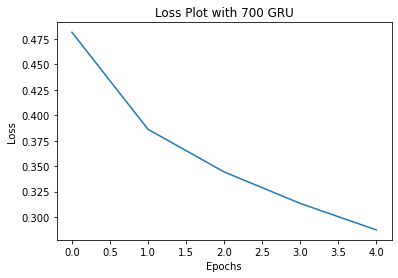

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot with 700 GRU')
plt.show()

##### Evaluation

Παρατηρώντας το παρακάτω caption βλέπουμε ότι αποτυγχάνει να εντοπίσει το κυρίως θέμα της εικόνας το οποίο αποτελεί το wheelchair επομένως δεν θεωρείται επιτυχές prediction caption.

Real Caption: <start> a wheelchair bound person receiving a tip from a passerby <end>
Prediction Caption: <start> three people are riding in blue sitting on a bicycle <end>


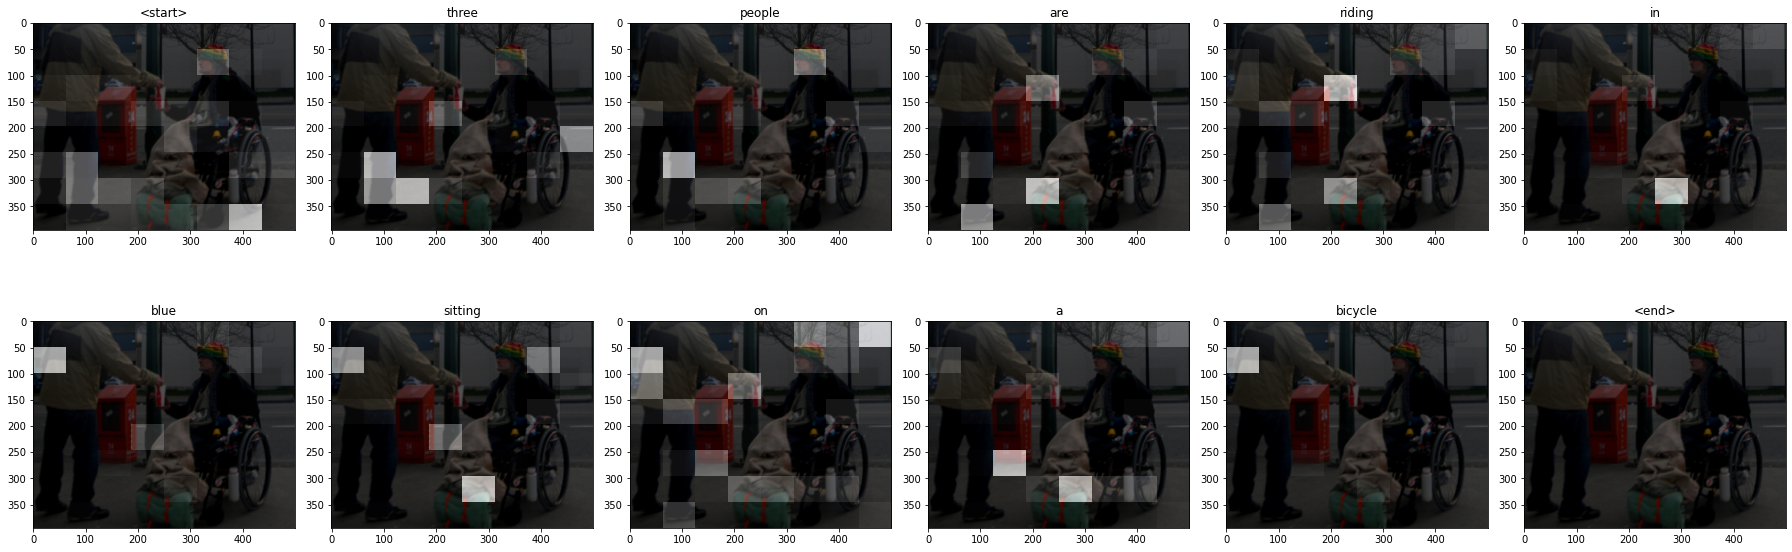

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image, encoder_reg, decoder_units_2)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

###### Backup

---




Στο συγκεκριμένο σημείο κρατάμε backup των αρχείων μας για μεταγενέστερη χρήση:

In [ ]:
joblib.dump(encoder_reg, './models/units/encoder_reg_units_2.pkl')
joblib.dump(decoder_units_2, './models/units/decoder_units_2.pkl')

#####Validation

---



In [ ]:
hypotheses = []
references = []

for img in tqdm(img_name_val_keys):
  refs = img_to_cap_vector[img]
  refs = [[tf.compat.as_text(index_to_word(i).numpy()) for i in lst if i not in [0]] for lst in refs]
  references.append(refs)

  hyp, _ = evaluate(img, encoder_reg, decoder_units_2)
  hypotheses.append(hyp)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [37:09<00:00,  1.86s/it]


######Backup

In [ ]:
joblib.dump(hypotheses, './models/bleu/units/units_2/hypotheses.pkl')
joblib.dump(references, './models/bleu/units/units_2/references.pkl')

######Bleu Scores

In [ ]:
hypotheses = joblib.load('./models/bleu/units/units_2/hypotheses.pkl')
references = joblib.load('./models/bleu/units/units_2/references.pkl')

Παρατηρούμε πάλι ότι το corpus bleu score μας είναι μεγαλύτερο από τις προηγούμενες εποχές και έχει μια πολύ καλή τιμή, οπότε υποπτευόμαστε ότι είναι η βέλτιστη επιλογή για το τελικό μας μοντέλο.

In [ ]:
maxbleu = 0
maxi = None

for i in range(len(references)):
  tmp = sentence_bleu(references[i], hypotheses[i])

  if tmp > maxbleu:
    maxbleu = tmp
    maxi = i

In [ ]:
print("Real Captions:")
for i in references[maxi]:
  print(" ".join(i))

print()
print("Predicted Caption:")
print(" ".join(hypotheses[maxi]))

print("Highest Sentence Bleu Score:", sentence_bleu(references[maxi], hypotheses[maxi]))

Real Captions:
<start> a man in a [UNK] shirt and white hat backdropped by a stone wall performs an unknown task while standing atop a platform <end>
<start> a man with a white camp is standing on a platform in front of a large black cylinder device and fabric on a clothesline <end>
<start> a man wearing a white cap standing a platform <end>
<start> a man stands upon his charcoal grill <end>
<start> man attempting to fix something <end>

Predicted Caption:
<start> a man with a container <end>
Highest Sentence Bleu Score: 0.721826999314566


In [ ]:
result = corpus_bleu(references, hypotheses)
print("Corpus Bleu Score =", result)

Corpus Bleu Score = 0.09243226393820754


#### Units = 512 LSTM

Εδώ δοκιμάσαμε LSTM units αντί για GRU προκειμένου να δούμε πως ανταποκρίνεται το νευρωνικό στην συγκεκριμένη αλλαγή.

In [ ]:
@tf.function
def train_step(img_tensor, target, encoder, decoder):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
units_3 = 512

In [ ]:
class Embeddings_Decoder_Reg_LSTM(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Embeddings_Decoder_Reg_LSTM, self).__init__()
    self.units = units

    self.embedding = embedding_layer
    self.LSTM = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.dropout = tf.keras.layers.Dropout(0.2)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state, cn = self.LSTM(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    x = self.dropout(x)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder_reg = CNN_Encoder(embedding_dim)
decoder_units_3 = Embeddings_Decoder_Reg_LSTM(embedding_dim, units_3, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
checkpoint_path = "./checkpoints/units/units_3"
ckpt = tf.train.Checkpoint(encoder=encoder_reg,
                           decoder=decoder_units_3,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

#####Training

---

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, encoder_reg, decoder_units_3)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 4.0964
Epoch 1 Batch 100 Loss 2.5493
Epoch 1 Batch 200 Loss 2.0414
Epoch 1 Batch 300 Loss 1.9162
Epoch 1 Loss 0.530955
Time taken for 1 epoch 310.50 sec

Epoch 2 Batch 0 Loss 1.7715
Epoch 2 Batch 100 Loss 1.8258
Epoch 2 Batch 200 Loss 1.6167
Epoch 2 Batch 300 Loss 1.5898
Epoch 2 Loss 0.422645
Time taken for 1 epoch 273.74 sec

Epoch 3 Batch 0 Loss 1.6577
Epoch 3 Batch 100 Loss 1.6581
Epoch 3 Batch 200 Loss 1.3447
Epoch 3 Batch 300 Loss 1.5474
Epoch 3 Loss 0.378297
Time taken for 1 epoch 210.05 sec

Epoch 4 Batch 0 Loss 1.4765
Epoch 4 Batch 100 Loss 1.3596
Epoch 4 Batch 200 Loss 1.4934
Epoch 4 Batch 300 Loss 1.2726
Epoch 4 Loss 0.347168
Time taken for 1 epoch 215.64 sec

Epoch 5 Batch 0 Loss 1.4193
Epoch 5 Batch 100 Loss 1.1997
Epoch 5 Batch 200 Loss 1.2854
Epoch 5 Batch 300 Loss 1.3288
Epoch 5 Loss 0.321693
Time taken for 1 epoch 222.52 sec



###### Loss plot

Σε σύγκριση με τους προηγούμενους πειραματισμούς, αυτό το είδος units δίνει ελάχιστα μεγαλύτερο loss στον ίδιο αριθμό εποχών και σε ελάχιστα μικρότερο χρόνο εκπαίδευσης.

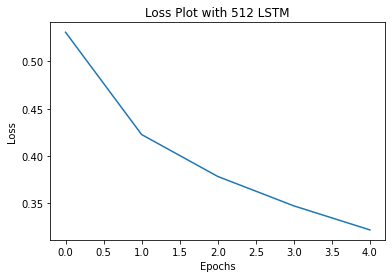

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot with 512 LSTM')
plt.show()

##### Evaluation

Στο παραγώμενο caption της τυχαίας εικόνας βλέπουμε ότι έχει μικρό μέγεθος και εντοπίζει αφαιρετικά το κυρίως θέμα της εικόνας χωρίς να μπαίνει σε λεπτομέρειες.

Real Caption: <start> youths sit and lie on blankets spread over a field of grass <end>
Prediction Caption: <start> a man shows a park <end>


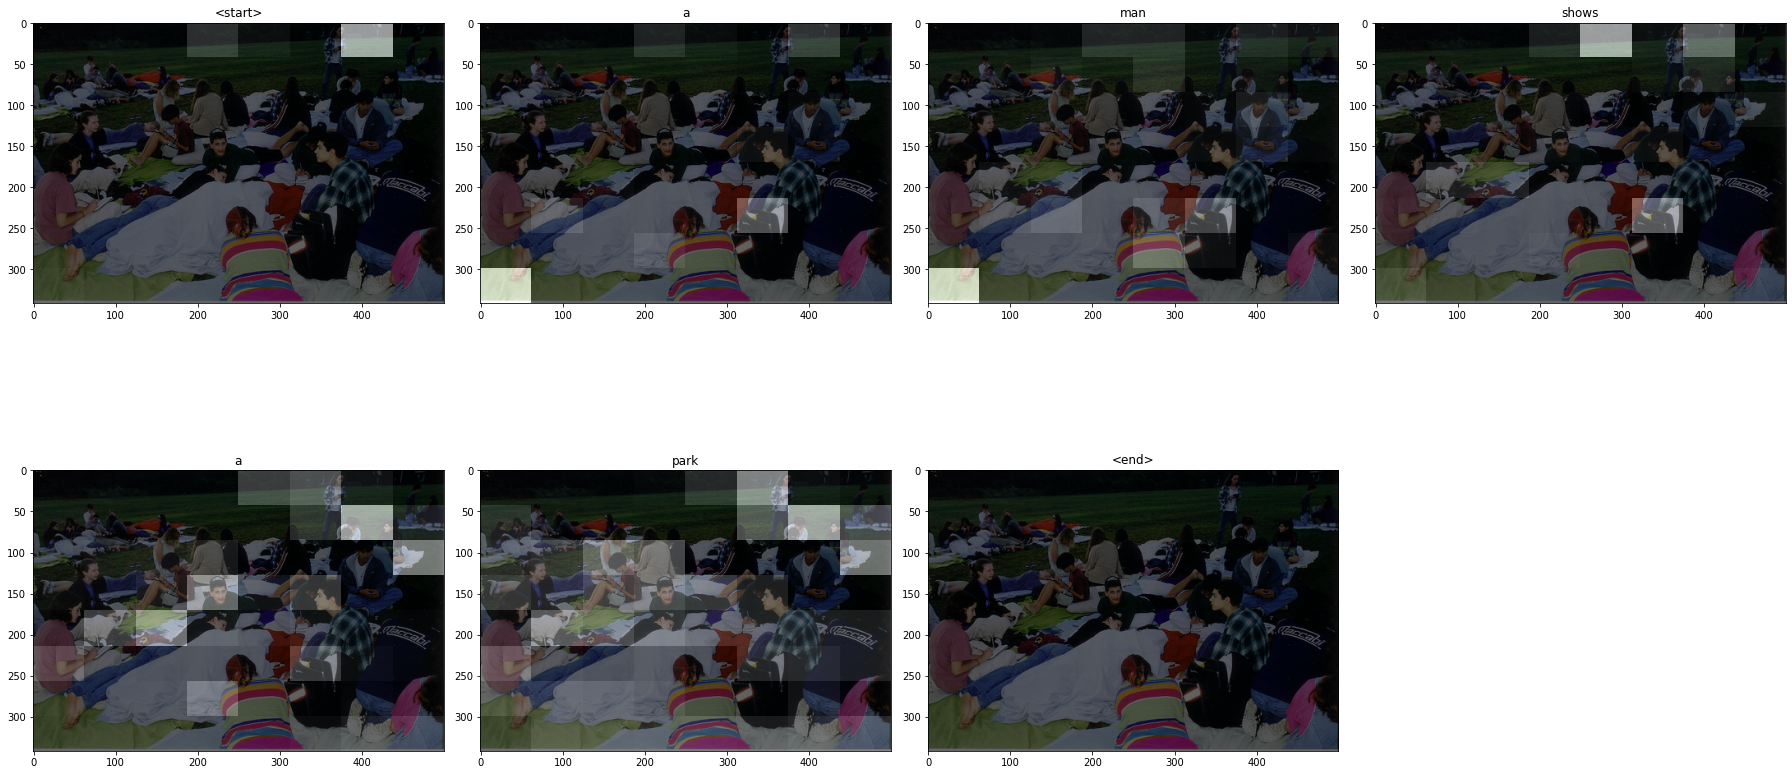

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image, encoder_reg, decoder_units_3)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

###### Backup

---




Στο συγκεκριμένο σημείο κρατάμε backup των αρχείων μας για μεταγενέστερη χρήση:

In [ ]:
joblib.dump(encoder_reg, './models/units/encoder_reg_units_3.pkl')


In [ ]:
joblib.dump(decoder_units_3, './models/units/decoder_units_3.pkl')


#####Validation

---



In [ ]:
hypotheses = []
references = []

for img in tqdm(img_name_val_keys):
  refs = img_to_cap_vector[img]
  refs = [[tf.compat.as_text(index_to_word(i).numpy()) for i in lst if i not in [0]] for lst in refs]
  references.append(refs)

  hyp, _ = evaluate(img, encoder_reg, decoder_units_3)
  hypotheses.append(hyp)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [37:12<00:00,  1.86s/it]


######Backup

In [ ]:
joblib.dump(hypotheses, './models/bleu/units/units_3/hypotheses.pkl')
joblib.dump(references, './models/bleu/units/units_3/references.pkl')

######Bleu Scores

In [ ]:
hypotheses = joblib.load('./models/bleu/units/units_3/hypotheses.pkl')
references = joblib.load('./models/bleu/units/units_3/references.pkl')

Συγκρινόμενα τα αποτελέσματα του decoder με 512 LSTM με αυτά των 700 GRU που ήταν βέλτιστος, βλέπουμε ότι είναι ελάχιστα μικρότερα, ωστόσο πάλι ικαννοποιητικά.

In [ ]:
maxbleu = 0
maxi = None

for i in range(len(references)):
  tmp = sentence_bleu(references[i], hypotheses[i])

  if tmp > maxbleu:
    maxbleu = tmp
    maxi = i

In [ ]:
print("Real Captions:")
for i in references[maxi]:
  print(" ".join(i))

print()
print("Predicted Caption:")
print(" ".join(hypotheses[maxi]))

print("Highest Sentence Bleu Score:", sentence_bleu(references[maxi], hypotheses[maxi]))

Real Captions:
<start> a man in a green shirt is working under a blue vehicle <end>
<start> a man wearing a green tshirt is working on a blue car <end>
<start> a man is working underneath a blue older model car <end>
<start> a man lays down to fix an old blue truck <end>
<start> someone working under a blue vehicle <end>

Predicted Caption:
<start> a man in a yellow car <end>
Highest Sentence Bleu Score: 0.6220921943331938


In [ ]:
result = corpus_bleu(references, hypotheses)
print("Corpus Bleu Score =", result)

Corpus Bleu Score = 0.08563421777618854


###Βέλτιστο Μοντέλο

Θα επιλέξουμε το βέλτιστο μοντέλο για να δούμε τι αποτελέσματα θα βγάλει όταν μπορέσει να εκπαιδευτεί για μεγαλύτερο αριθμό εποχών. To μοντέλο αυτό περιέχει:
* Captions που έχουν υποστεί προεπεξεργασία
* Τον encoder NASNet Large
* Embeddings με transfer learning
* Dropout layers με πιθανότητα 0.2
* 700 GRU units

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 16
BUFFER_SIZE = 1000
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 4032
attention_features_shape = 121

In [ ]:
@tf.function
def train_step(img_tensor, target, encoder, decoder):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
units_2 = 700

In [ ]:
encoder_final = CNN_Encoder(embedding_dim)
decoder_final = Embeddings_Decoder_Reg(embedding_dim, units_2, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
checkpoint_path = "./checkpoints/final"
ckpt = tf.train.Checkpoint(encoder=encoder_final,
                           decoder=decoder_final,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

#####Training

---

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

Πραγματοποιήσαμε την εκπαίδευση για 30 εποχές, αριθμός που θεωρήσαμε ότι ήταν ικανοποιητικός αναλογιζόμενοι τους περιορισμούς που διαθέτουμε όσον αφορά τους πόρους.

In [ ]:
EPOCHS = 30

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, encoder_final, decoder_final)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 2 Batch 0 Loss 1.8483
Epoch 2 Batch 100 Loss 1.4350
Epoch 2 Batch 200 Loss 1.6636
Epoch 2 Batch 300 Loss 1.4265
Epoch 2 Loss 0.386901
Time taken for 1 epoch 326.12 sec

Epoch 3 Batch 0 Loss 1.5442
Epoch 3 Batch 100 Loss 1.3094
Epoch 3 Batch 200 Loss 1.4348
Epoch 3 Batch 300 Loss 1.3625
Epoch 3 Loss 0.345196
Time taken for 1 epoch 261.67 sec

Epoch 4 Batch 0 Loss 1.4242
Epoch 4 Batch 100 Loss 1.2129
Epoch 4 Batch 200 Loss 1.2475
Epoch 4 Batch 300 Loss 1.2342
Epoch 4 Loss 0.313959
Time taken for 1 epoch 241.24 sec

Epoch 5 Batch 0 Loss 1.2254
Epoch 5 Batch 100 Loss 1.1859
Epoch 5 Batch 200 Loss 1.2510
Epoch 5 Batch 300 Loss 1.0362
Epoch 5 Loss 0.288602
Time taken for 1 epoch 241.22 sec

Epoch 6 Batch 0 Loss 1.0857
Epoch 6 Batch 100 Loss 0.9528
Epoch 6 Batch 200 Loss 1.1891
Epoch 6 Batch 300 Loss 1.0390
Epoch 6 Loss 0.265695
Time taken for 1 epoch 240.12 sec

Epoch 7 Batch 0 Loss 1.0291
Epoch 7 Batch 100 Loss 0.9911
Epoch 7 Batch 200 Loss 0.9777
Epoch 7 Batch 300 Loss 0.9730
Epoch 7

###### Loss plot

Παρατηρούμε τώρα ότι το loss έχει πάρει μία ελάχιστη τιμή και ότι ο χρόνος εκπαίδευσης παραμένει σε ικανοποιητικά επίπεδα (περίπου 4.5 λεπτά/εποχή). Τα βέλτιστα αυτά αποτελέσματα αποτυπώνονται και στην παρακάτω γραφική παράσταση η οποία δεν παρουσιάζει ακμές.

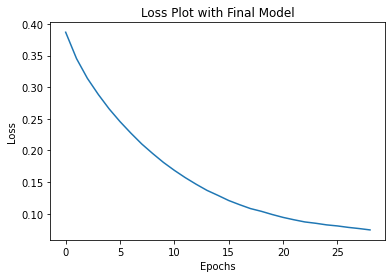

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot with Final Model')
plt.show()

Στην συνέχεια το τρέξαμε για 20 ακόμα εποχές, χωρίς να δημιουργήσουμε κάποια γραφική παράσταση,προκειμένου να δούμε αν υφίσταται περαιτέρω βελτίωση.

In [ ]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, encoder_final, decoder_final)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 31 Batch 0 Loss 0.2739
Epoch 31 Batch 100 Loss 1.0180
Epoch 31 Batch 200 Loss 0.9515
Epoch 31 Batch 300 Loss 0.7644
Epoch 31 Loss 0.236088
Time taken for 1 epoch 422.21 sec

Epoch 32 Batch 0 Loss 0.6941
Epoch 32 Batch 100 Loss 0.5408
Epoch 32 Batch 200 Loss 0.4755
Epoch 32 Batch 300 Loss 0.4758
Epoch 32 Loss 0.125131
Time taken for 1 epoch 390.20 sec

Epoch 33 Batch 0 Loss 0.4546
Epoch 33 Batch 100 Loss 0.3393
Epoch 33 Batch 200 Loss 0.3710
Epoch 33 Batch 300 Loss 0.3781
Epoch 33 Loss 0.095674
Time taken for 1 epoch 315.49 sec

Epoch 34 Batch 0 Loss 0.3584
Epoch 34 Batch 100 Loss 0.3125
Epoch 34 Batch 200 Loss 0.3144
Epoch 34 Batch 300 Loss 0.3191
Epoch 34 Loss 0.082996
Time taken for 1 epoch 279.67 sec

Epoch 35 Batch 0 Loss 0.2628
Epoch 35 Batch 100 Loss 0.2675
Epoch 35 Batch 200 Loss 0.3500
Epoch 35 Batch 300 Loss 0.2760
Epoch 35 Loss 0.075813
Time taken for 1 epoch 296.00 sec

Epoch 36 Batch 0 Loss 0.2648
Epoch 36 Batch 100 Loss 0.2722
Epoch 36 Batch 200 Loss 0.2868
Epoch 36 

Παρατηρούμε ότι στις τελευταίες εποχές το loss μειώνεται ελάχιστα επομένως δεν υπάρχει λόγος να εκπαιδεύσουμε το μοντέλο για παραπάνω εποχές μιας και πλέον το loss έχει πλησιάσει σε ένα σημείο ευστάθειας.

##### Evaluation

Παρατηρούμε ότι το prediction caption έχει πολλά κοινά στοιχεία με το real caption κάτι το οποίο μας προϊδεάζει ότι το τελικό μας μοντέλο είναι πράγματι βέλτιστο.

Real Caption: <start> a musical concert with a crowd cheering to the band on stage <end>
Prediction Caption: <start> a band is singing on stage and big crowd looks on <end>


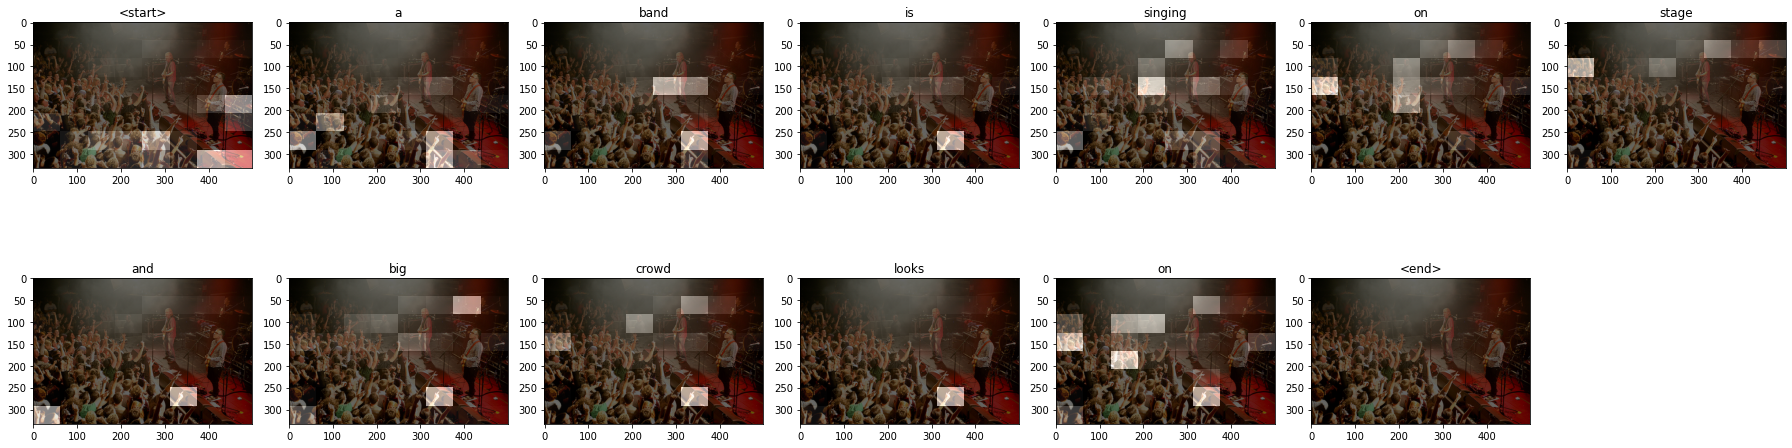

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image, encoder_final, decoder_final)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

###### Backup

---




Στο συγκεκριμένο σημείο κρατάμε backup των αρχείων μας για μεταγενέστερη χρήση:

In [ ]:
import joblib

In [ ]:
joblib.dump(encoder_final, './models/final/encoder_final.pkl')
joblib.dump(decoder_final, './models/final/decoder_final.pkl')

#####Validation

---



In [ ]:
hypotheses = []

for img in tqdm(img_name_val_keys):

  hyp, _ = evaluate(img, encoder_final, decoder_final)
  hypotheses.append(hyp)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [21:08<00:00,  1.06s/it]


In [ ]:
references =[]

for img in tqdm(img_name_val_keys):
  refs = img_to_cap_vector[img]
  refs = [[tf.compat.as_text(index_to_word(i).numpy()) for i in lst if i not in [0]] for lst in refs]
  references.append(refs)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [19:17<00:00,  1.04it/s]


######Backup

In [ ]:
joblib.dump(hypotheses, './models/bleu/final/hypotheses.pkl')
joblib.dump(references, './models/bleu/final/references.pkl')

######Bleu Scores

In [ ]:
hypotheses = joblib.load('./models/bleu/final/hypotheses.pkl')
references = joblib.load('./models/bleu/final/references.pkl')

Αναφορικά με το corpus bleu για το μοντέλο μετά από 30 εποχές, παρατηρούμε ότι έχει μία πολύ καλή τιμή η οποία είναι καλύτερη από το baseline, όπως επιθυμούσαμε.

In [ ]:
maxbleu = 0
maxi = None

for i in range(len(references)):
  tmp = sentence_bleu(references[i], hypotheses[i])

  if tmp > maxbleu:
    maxbleu = tmp
    maxi = i

In [ ]:
print("Real Captions:")
for i in references[maxi]:
  print(" ".join(i))

print()
print("Predicted Caption:")
print(" ".join(hypotheses[maxi]))

print("Highest Sentence Bleu Score:", sentence_bleu(references[maxi], hypotheses[maxi]))

Real Captions:
<start> a man in an orange vest and blue hat smiles next to a large piece of equipment <end>
<start> a man with orange vest and blue cap standing next to electronic equipment <end>
<start> a man in a safety vest is posing in front of some technical equipment <end>
<start> a man demonstrating how a computer system works <end>
<start> working in a nice factory <end>

Predicted Caption:
<start> a man in an orange jacket <end>
Highest Sentence Bleu Score: 0.788238465735608


In [ ]:
result = corpus_bleu(references, hypotheses)
print("Corpus Bleu Score =", result)

Corpus Bleu Score = 0.11803186464050296


#####Validation after 50 epochs

---



In [ ]:
hypotheses = []

for img in tqdm(img_name_val_keys):

  hyp, _ = evaluate(img, encoder_final, decoder_final)
  hypotheses.append(hyp)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [19:25<00:00,  1.03it/s]


In [ ]:
references =[]

for img in tqdm(img_name_val_keys):
  refs = img_to_cap_vector[img]
  refs = [[tf.compat.as_text(index_to_word(i).numpy()) for i in lst if i not in [0]] for lst in refs]
  references.append(refs)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [17:58<00:00,  1.11it/s]


######Backup

In [ ]:
joblib.dump(hypotheses, './models/bleu/final/hypotheses.pkl')
joblib.dump(references, './models/bleu/final/references.pkl')

######Bleu Scores

In [ ]:
hypotheses = joblib.load('./models/bleu/final/hypotheses.pkl')
references = joblib.load('./models/bleu/final/references.pkl')

Για το ίδιο μοντέλο μετά από 50 εποχές, τα αποτελέσματα είναι ακόμα καλύτερα από πριν, κάτι το οποίο αποδεικνύει ότι η εκπαίδευση για περισσότερες εποχές επέδρασε θετικά στο corpus bleu.  Περαιτέρω αύξηση του corpus blue θα μπορούσε να επιτευχθεί εαν δοκιμάζαμε περισσότερες βελτιώσεις και ίσως περισσότερες εποχές.

In [ ]:
maxbleu = 0
maxi = None

for i in range(len(references)):
  tmp = sentence_bleu(references[i], hypotheses[i])

  if tmp > maxbleu:
    maxbleu = tmp
    maxi = i

In [ ]:
print("Real Captions:")
for i in references[maxi]:
  print(" ".join(i))

print()
print("Predicted Caption:")
print(" ".join(hypotheses[maxi]))

print("Highest Sentence Bleu Score:", sentence_bleu(references[maxi], hypotheses[maxi]))

Real Captions:
<start> a young woman wearing a yellow shirt and offwhite shorts is reading a book while sitting on a park bench <end>
<start> a man with black hair is lying across a park bench reading a book <end>
<start> a woman is sitting on a bench reading in a park <end>
<start> woman reading a book on a park bench outside <end>
<start> a woman sitting on a bench reading a book <end>

Predicted Caption:
<start> a man and a woman sitting on a bench <end>
Highest Sentence Bleu Score: 0.7652578084809538


In [ ]:
result = corpus_bleu(references, hypotheses)
print("Corpus Bleu Score =", result)

Corpus Bleu Score = 0.11642924540198267


###Sentence Generator

Τέλος, μας ζητήθηκε να πειράξουμε την συνάρτηση evaluate προκειμένου να  χρησιμοποιήσουμε την beam search έναντι της random.categorical που χρησιμοποιούσαμε μέχρι στιγμής.

Για την υλοποίηση του αλγόριθμου *Beam Search* επιλέξαμε να δημιουργήσουμε μία κλάση η οποία κάνει τους κατάλληλους υπολογισμούς. Η *Beam Search* ουσιαστικά εκτελεί έναν αλγόριθμο *BFS*, ο οποίος ωστόσο έχει μέτωπο αναζήτησης περιορισμένου μεγέθους, καλούμενο ακτίνα αναζήσης $b$. Σε κάθε επανάληψη ξεκινάμε με *b* προτάσεις στο μέτωπο αναζήτησης, όπου η κάθεμία από αυτές παράγει μέσω του *decoder* $7000 ( = vocabulary\_size)$ νέα ενδεχόμενα και υπολογίζει τις πιθανότητές τους. Κρατάμε τις $b$ προτάσεις με την μεγαλύτερη πιθανότητα, και περνάμε στην επόμενη αναζήτηση. Όποια πρόταση τελειώνει με την λέξη **\<end>** δεν παράγει νέα ενδεχόμενα, αλλά περνάει αυτούσια ως υποψήφια για το επόμενο μέτωπο αναζήτησης. Η αναζήτηση ολοκληρώνεται όταν όλες οι προτάσεις στο μέτωπο αναζήτησης τελειώνουν στην λέξη **\<end>** ή όταν φτάσουμε το μέγιστο μήκος πρότασης. 

Επειδή για να βρούμε την πιθανότητα μιας πρότασης πολλαπλασιάζουμε τις διαδοχικές πιθανότητες των λέξεων της, θα καταλήγαμε με πολύ μικρούς αριθμούς το οποίο θα δημιουργούσε προβλήματα ακρίβειας ή underflow. Για αυτό μετατρέπουμε τις πιθανότητες σε λογαρίθμους τους οποίους προσθέτουμε, ώστε να διατηρήσουμε τη μονοτονία και να διευκολύνουμε τις πράξεις.

Η υλοποίηση της *Beam Search* είναι ιδιαίτερα απαιτητική σε χρόνο γιατί παράγει $b*vocabulary\_size$ ενδεχόμενα σε κάθε επανάληψη τα οποία πρέπει να ταξινομούνται κάθε φορά. Για αυτό δεν ήταν δυνατή η δοκιμή τους πάνω σε ολόκληρο το *validation set* οπότε επιλέξαμε ένα υποσύνολο για να μπορέσουμε να κάνουμε τη σύγκριση. Επίσης χρειάστηκε να αναθεωρηθεί κάποιες φορές η υλοποίησή μας, καθώς κάθε πρόταση του μετώπου αναζήτησης περιέχει όλα τα tokens που προηγούνται, και η αντιγραφή πινάκων τόσες φορές όδηγούσε σε προβλήματα αποδοτικότητας.

In [ ]:
class BeamSearch:
  def __init__(self, features, decoder, max_length, b = 1):
    self.features = features
    self.decoder = decoder
    self.max_length = max_length
    self.b = b
    #self.attention_plot = np.zeros((max_length, attention_features_shape))

    tmp_hidden = decoder.reset_state(batch_size=1)
    tmp_start = tf.expand_dims([word_to_index('<start>')], 0)
    #print(tmp_start)
    #print(type(tmp_start))
    self.top_preds = [([tmp_start], tmp_hidden, 0)]

  def compute(self):
    for i in range(max_length):
      tmp_preds = []
      for path in self.top_preds:

        #print(path[0])
        last_word = tf.compat.as_text(index_to_word(path[0][-1][0][0]).numpy())
        if last_word == '<end>':
            tmp_preds.append(path)
            continue

        predictions, tmp_hidden, _ = self.decoder( path[0][-1],
                                              self.features,
                                              path[1])
        #print(predictions)
        

        #αν εν τέλει βάλουμε attention plot θα χρειαστεί αλλαγή
        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        

        predictions = tf.nn.softmax(predictions[0])
        new_probs = sorted([(x[0], path[2] + math.log(x[1])) for x in enumerate(predictions)], key = lambda x : x[1], reverse=True)[:self.b]
        #best = sorted(enumerate(predictions), key = lambda x : x[1], reverse=True)[:3]
        predictions = [(path[0] + [np.array([[x[0]]])], tmp_hidden, x[1]) for x in new_probs]

        tmp_preds.extend(predictions)

        #predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        #result.append(predicted_word)

      new_preds = sorted(tmp_preds, key = lambda x : x[2]/len(x[0]), reverse=True)[:self.b]
      self.top_preds = new_preds
      #print("TMP PREDS:")
      #print("TMP PREDS:", tmp_preds.getList())

    return

  def results(self):
    res = []
    for path in self.top_preds.getList():
      sentence = path[0]
      sentence = [tf.compat.as_text(index_to_word(word[0][0]).numpy()) for word in sentence]
      if sentence[-1] == "<end>":
        sentence = sentence[:-1]
      res.append(sentence, path[2])

    return res

  def bestResult(self):
    sentence = self.top_preds[0][0]
    sentence = [tf.compat.as_text(index_to_word(word[0][0]).numpy()) for word in sentence]
    if sentence[-1] == "<end>":
        sentence = sentence[:-1]
    return sentence

In [ ]:
def evaluateBeamSearch(image, encoder, decoder, b = 1):
    #attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = nasnet_image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    beam_search = BeamSearch(features, decoder, max_length, b)
    beam_search.compute()
    #print(beam_search.results())
    return beam_search.bestResult()

#####Validation στο βέλτιστο μοντέλο

---



In [ ]:
references = joblib.load('./models/bleu/final/references.pkl')

Κρατάμε ένα υποσύνολο των δειγμάτων:

In [ ]:
references = references[:80]

####Δοκιμές με διαφορετικά b

######$b=2$

In [ ]:
hypothesesk2 = []

for img in tqdm(img_name_val_keys[:80]):

  hyp = evaluateBeamSearch(img, encoder_final, decoder_final, 2)
  hypothesesk2.append(hyp)

100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [3:27:11<00:00, 155.40s/it]


In [ ]:
joblib.dump(hypothesesk2, './backups/beamsearch/hypothesesk2.pkl')

['./backups/beamsearch/hypothesesk2.pkl']

######$b=3$

In [ ]:
hypothesesk3 = []

for img in tqdm(img_name_val_keys[:80]):

  hyp = evaluateBeamSearch(img, encoder_final, decoder_final, 3)
  hypothesesk3.append(hyp)

100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [5:56:52<00:00, 267.66s/it]


In [ ]:
joblib.dump(hypothesesk3, './backups/beamsearch/hypothesesk3.pkl')

['./backups/beamsearch/hypothesesk3.pkl']

######$b=4$

In [ ]:
hypothesesk4 = []

for img in tqdm(img_name_val_keys[:80]):

  hyp = evaluateBeamSearch(img, encoder_final, decoder_final, 4)
  hypothesesk4.append(hyp)

100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [6:21:25<00:00, 286.07s/it]


In [ ]:
joblib.dump(hypothesesk4, './backups/beamsearch/hypothesesk4.pkl')

['./backups/beamsearch/hypothesesk4.pkl']

######Control

In [ ]:
hypotheses = []

for img in tqdm(img_name_val_keys[:80]):

  hyp , _ = evaluate(img, encoder_final, decoder_final)
  hypotheses.append(hyp)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:23<00:00,  1.04s/it]


In [ ]:
joblib.dump(hypotheses, './backups/beamsearch/control.pkl')

['./backups/beamsearch/control.pkl']

#####Σύγκριση

Διαλέγουμε μία τυχαία εικόνα από τα δείγματα μας και παρουσιάζουμε τα real και predicted captions για διαφορετικές τιμές του b.

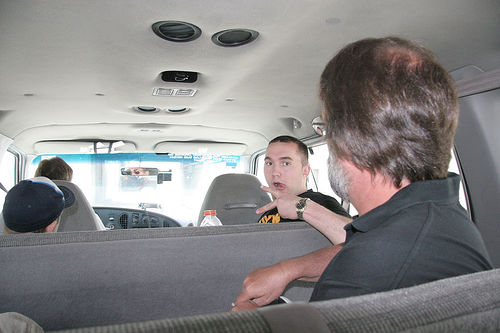

In [ ]:
rid = np.random.randint(0, 80)

image = img_name_val_keys[rid]
Image.open("./image_dir/" + image)

In [ ]:
print("Real Captions:")
for i in references[rid]:
  print(" ".join(i))

eval_models = { "Original": hypotheses[rid],
                "Beam Search b=2": hypothesesk2[rid],
                "Beam Search b=3": hypothesesk3[rid],
                "Beam Search b=4": hypothesesk4[rid]}

for x in eval_models:
  print()
  print("Evaluation = ", x)
  print("Predicted Caption:")
  print(" ".join(eval_models[x]))
  print("Sentence Bleu Score:", sentence_bleu(references[rid], eval_models[x]))

Real Captions:
<start> a young man flashes the peace sign to an older man with a bald spot in the backseat of a van <end>
<start> four guys in a car with one in the middle seat turned backwards looking at the camera <end>
<start> four men in a van one man turned around giving peace sign to man behind him <end>
<start> a boy sits facing backwards in a car while making a peace sign <end>
<start> four people are in a automobile <end>

Evaluation =  Original
Predicted Caption:
<start> man sitting on the window from the back of the car in a stocking boat <end>
Sentence Bleu Score: 0.07313151007403206

Evaluation =  Beam Search b=2
Predicted Caption:
<start> a man sits on the window from the back of the car
Sentence Bleu Score: 0.043110523084692064

Evaluation =  Beam Search b=3
Predicted Caption:
<start> a man sits on the window from the back of the car
Sentence Bleu Score: 0.043110523084692064

Evaluation =  Beam Search b=4
Predicted Caption:
<start> a man looks at the window
Sentence Bleu

Ερμηνεία:

Φαίνεται αξιοπερίεργο με πρώτη ματιά που η αναζήτηση με μεγαλύτερο $b$ καταλήγει σε μικρότερο score (μεταξύ του original evaluation και του evaluation με b = 2), ωστόσο κάτι τέτοιο δεν είναι απαραίτητο οτι θα συμβαίνει πάντα. Εφόσον δεν είναι εξαντλητικός ο *BFS* που εφαρμόζει ο αλγόριθμος, δεν εγγυόμαστε ότι θα καταλήξουμε κάθε φορά στο βέλτιστο αποτέλεσμα. Ωστόσο, αυξάνοντας το *beam width* μπορούμε να μετατοπιστούμε σε άλλα *τοπικά μέγιστα*. Έτσι, ενώ με χαμηλό *beam width* θα εγκλωβιστούμε σίγουρα σε τοπικό μέγιστο και θα προσομοιώσουμε την εκτέλεση ενός greedy αλγόριθμου, με την μεγαλύτερη ακτίνα μπορεί να μετατοπιστούμε προς ένα άλλο μέγιστο που είναι πιο πολλά υποσχόμενο σε νωρίτερες επαναλήψεις αλλά στη συνέχεια καταλήγει να έχει χαμηλότερη τιμή από αυτό που βρίσκει ο greedy, το οποίο πλέον δεν ανήκει στο μέτωπο αναζήτησης.

In [ ]:
print("For Beam Search with width = " + str(2) + ", corpus bleu score = " + str(corpus_bleu(references, hypothesesk2)))

For Beam Search with width = 2, corpus bleu score = 0.14453772421044744


In [ ]:
print("For Beam Search with width = " + str(3) + ", corpus bleu score = " + str(corpus_bleu(references, hypothesesk3)))

For Beam Search with width = 3, corpus bleu score = 0.16720573973716393


In [ ]:
print("For Beam Search with width = " + str(4) + ", corpus bleu score = " + str(corpus_bleu(references, hypothesesk4)))

For Beam Search with width = 4, corpus bleu score = 0.17925262019625715


In [ ]:
bleus = [["Original", corpus_bleu(references, hypotheses)],
         ["Beam Search b=2", corpus_bleu(references, hypothesesk2)],
         ["Beam Search b=3", corpus_bleu(references, hypothesesk3)],
         ["Beam Search b=4", corpus_bleu(references, hypothesesk4)]]

In [ ]:
from tabulate import tabulate
print(tabulate(bleus))

---------------  --------
Original         0.129969
Beam Search b=2  0.144538
Beam Search b=3  0.167206
Beam Search b=4  0.179253
---------------  --------


Με βάση τα παραπάνω αποτελέσματα παρατηρούμε ότι η beam search πράγματι αύξησε κατά ένα μεγάλο βαθμό την απόδοση του νευρωνικού μας μοντέλου όσον αφορά το corpus bleu score. Συγκριτικά με το baseline (corpus bleu = 0.129969), το μοντέλο που κάνει χρήση της beam search για b = 4 παράγει αρκετά βελτιωμένο corpus bleu ( = 0.179253). Παρ'όλα αυτά, η χρήση της beam search εισάγει ένα trade-off μεταξύ χρόνου-απόδοσης καθώς προκειμένου να εφαρμοστεί σε όλο το dataset θα χρειαζόταν χρόνο εκπαίδευσης που ισούται με σχεδόν 2 ημέρες παρ'όλες τις προσπάθειες βελτιστοποίησης που καταβάλαμε, αριθμός ο οποίος θεωρείται απαγορευτικός για ένα dataset τέτοιου μεγέθους. 